# Import Packages

In [1]:
import pandas as pd #<- package used to import and organize data
import numpy as np #<- package used to import and organize data
import math
import os #<- package used to work with system file paths
import seaborn as sns #<- package used to plot graphs
from matplotlib import pyplot as plt #<- another package used to plot graphs
from itertools import cycle #<- package used to iterate down rows (used in step 5 to add tap column)
import ipywidgets as widgets #<- widget tool to generate button and tab for graphs
from IPython.display import display #<- displays widgets
from ipyfilechooser import FileChooser
import pingouin as pg
from pingouin import ttest
from scipy.stats import ttest_ind
import tqdm
print("done step 1")

done step 1


/Users/rankinlab/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Designate Directory

In [2]:
starting_directory = '/Users'
chooser = FileChooser(starting_directory)
display(chooser)

FileChooser(path='/Users', filename='', title='', show_hidden=False, select_desc='Select', change_desc='Change…

In [6]:
print(chooser.selected_path)
folder_path=chooser.selected_path

/Users/rankinlab/Desktop/Kristen/Grouped_vps-35


# To Read In Tap Response Data:

### Setting Tap Paramaters Here...

In [4]:
number_of_taps = 30 ###<------ Taps in your experiment.

number_taps = range(1, number_of_taps + 1)  #<- do not change this


# if you have different ISIs in the same folder, then come back and change this 
# when you are graphing for the second set of data with the other ISI 
# (Generally data from same ISIs are graphed together)
# If changing ISI mid-analysis, you can just skip straight to step 8 after running this cell again

ISI = 10  ### <- What is your ISI? change accordingly
first_tap = 600 ### <- when is your first tap? check your TRV files

#Here, open up one of the trv files to determine the times for each of these taps. 
lower = np.arange(first_tap-1, first_tap-1+(number_of_taps*ISI), ISI) #(first tap, last tap+10s, ISI)
upper = np.arange(first_tap+1, first_tap+1+(number_of_taps*ISI), ISI) #(first tap, last tap+10s, ISI)
tolerances = list(zip(lower, upper)) 
taps = [i for i in range(1,number_of_taps+1)]

#### Add 31st Tap Here --------------------------------------------------<------------
tolerances.append((1188,1191))
taps.append(31)


#assign each tolerance to a tap number
accurate_taps = list((zip(taps, tolerances)))
print(accurate_taps)

for pair in accurate_taps:
   tap = pair[0]
   tolerance = pair[1]
   print("tap "+str(tap), "tolerance="+str(tolerance))

print("done step 3")

[(1, (599, 601)), (2, (609, 611)), (3, (619, 621)), (4, (629, 631)), (5, (639, 641)), (6, (649, 651)), (7, (659, 661)), (8, (669, 671)), (9, (679, 681)), (10, (689, 691)), (11, (699, 701)), (12, (709, 711)), (13, (719, 721)), (14, (729, 731)), (15, (739, 741)), (16, (749, 751)), (17, (759, 761)), (18, (769, 771)), (19, (779, 781)), (20, (789, 791)), (21, (799, 801)), (22, (809, 811)), (23, (819, 821)), (24, (829, 831)), (25, (839, 841)), (26, (849, 851)), (27, (859, 861)), (28, (869, 871)), (29, (879, 881)), (30, (889, 891)), (31, (1188, 1191))]
tap 1 tolerance=(599, 601)
tap 2 tolerance=(609, 611)
tap 3 tolerance=(619, 621)
tap 4 tolerance=(629, 631)
tap 5 tolerance=(639, 641)
tap 6 tolerance=(649, 651)
tap 7 tolerance=(659, 661)
tap 8 tolerance=(669, 671)
tap 9 tolerance=(679, 681)
tap 10 tolerance=(689, 691)
tap 11 tolerance=(699, 701)
tap 12 tolerance=(709, 711)
tap 13 tolerance=(719, 721)
tap 14 tolerance=(729, 731)
tap 15 tolerance=(739, 741)
tap 16 tolerance=(749, 751)
tap 17 to

### Constructing .trv filelist

In [7]:
os.chdir(folder_path) #<- setting your working directory so that your images will be saved here

filelist = list() #<- empty list
for root, dirs, files in os.walk(folder_path): #<- this for loop goes through your folder 
    for name in files:
        if name.endswith('.trv'): #<- and takes out all files with a .trv (file that contains your data)
            filepath = os.path.join(root, name) #<- Notes down the file path of each data file
            filelist.append(filepath) #<- saves it into the list
    
print(filelist)
print('done step 4')

['/Users/rankinlab/Desktop/Kristen/Grouped_vps-35/N2/20220802_162451/N2_10x2_f96h20C_600s30x10s10s_A0802ad.trv', '/Users/rankinlab/Desktop/Kristen/Grouped_vps-35/N2/20220802_142547/N2_10x2_f96h20C_600s30x10s10s_A0802aa.trv', '/Users/rankinlab/Desktop/Kristen/Grouped_vps-35/N2/20220802_141805/N2_10x2_f72h20C_600s31x10s10s_B0802ab.trv', '/Users/rankinlab/Desktop/Kristen/Grouped_vps-35/N2/20221014_134354/N2_10x2_f96h20C_600s31x10s10s_A1014ad.trv', '/Users/rankinlab/Desktop/Kristen/Grouped_vps-35/N2/20220802_144042/N2_10x2_f72h20C_600s31x10s10s_C0802ac.trv', '/Users/rankinlab/Desktop/Kristen/Grouped_vps-35/N2/20220802_161705/N2_10x2_f72h20C_600s31x10s10s_B0802ae.trv', '/Users/rankinlab/Desktop/Kristen/Grouped_vps-35/N2/20221014_131632/N2_10x2_f72h20C_600s31x10s10s_C0928ac.trv', '/Users/rankinlab/Desktop/Kristen/Grouped_vps-35/N2/20221014_124409/N2_10x2_f72h20C_600s31x10s10s_B1014ab.trv', '/Users/rankinlab/Desktop/Kristen/Grouped_vps-35/vps-35_ok1880/20221014_141302/VC1390_10x2_f96h20C_600s

### generating list of strains (groups)

In [8]:
genotype=[]
for f in filelist:
    genotype.append(f.split('/')[6])
# print(np.unique(genotype))
genotypes=np.unique(genotype)
# print(genotypes)
# print(len(np.unique(genotypes)))
strainNs = enumerate(genotypes,1)
strain_enum=list(strainNs)
print(strain_enum)
StrainNames=dict(strain_enum)
print(StrainNames)

[(1, 'N2'), (2, 'vps-35_hu68'), (3, 'vps-35_ok1880')]
{1: 'N2', 2: 'vps-35_hu68', 3: 'vps-35_ok1880'}


### Defining functions to reading in data

In [9]:
def Tap_ProcessData(strain): #<- an example of a user-defined function
    strain_filelist = [x for x in filelist if strain in x] #<- goes through the list and filters for keyword
    Strain_N = len(strain_filelist) #<- N per strain, or number of plates
    Plate_N = 1
    print(f'this strain/treatment has {Strain_N} plates') #<- will output as the first number
    if Strain_N == 0:
        raise AssertionError ('{} is not a good identifier'.format(strain))
    else:
        pass
#     for f in strain_filelist:
#         DF_Total = pd.concat(pd.read_csv(f, sep=' ', skiprows = 4, header = None))
        DF_Total = pd.concat([pd.read_csv(f, sep=' ', header = None, encoding_errors='ignore') for f in strain_filelist],
                      ignore_index=True) #<- imports your data files
#         DF_Total = DF_Total.dropna(axis = 1) #<- cleans your data
        DF_Total = DF_Total.rename( #<- more cleaning
                    {0:'time',
                    2:'rev_before',
                    3:'no_rev',
                    4:'stim_rev',
                    7:'dist',
                    8:'dist_std',
                    9:'dist_stderr',
                    11:'dist_0th',
                    12:'dist_1st',
                    13:'dist_2nd',
                    14:'dist_3rd',
                    15:'dist_100th',
                    18:'dura',
                    19:'dura_std',
                    20:'dura_stderr',
                    22:'dura_0th',
                    23:'dura_1st',
                    24:'dura_2nd',
                    25:'dura_3rd',
                    26:'dura_100th'}, axis=1)
        #check function here for NaN Columns
        DF_Total['plate'] = 0
        DF_Total['prob'] = DF_Total['stim_rev']/ (DF_Total['no_rev'] + DF_Total['stim_rev']) #<- calculate prob
        DF_Total['speed'] = DF_Total['dist']/DF_Total['dura'] #<- calculate speed
        DF_Total_rows = int(DF_Total.shape[0])
        print(f'this strain/treatment has {DF_Total_rows} total taps') #<- Outputs as the second number. Check if you are missing taps!
        DF_Final = DF_Total[["time", "dura", "dist", "prob", "speed", "plate"]].copy()

    return{
            'N': Strain_N,
            'Confirm':DF_Total,
            'Final': DF_Final}
    print('done!')



def assign_taps(DF, tolerances):
    """This function inserts a taps column,
    and assigns a tap number to each row 
    based on the tolerances described prior.
    
    :param DF: any dataframe
    :type: pandas.core.frame.DataFrame
    :param tolerances: list of tuples
    :type: tuple
    
    :return: dataframe with a plate column
    :type: pandas.core.frame.DataFrame
    """
    DF['taps'] = ""
    for taps, tolerance in enumerate(tolerances): #[(99, 101), (109,111), ...]
        tap_lower,tap_upper = tolerance
        TimesInTapRange = DF['time'].between(tap_lower,tap_upper, inclusive="both")
        DF.loc[TimesInTapRange,'taps'] = taps+1 #set the tap to i where times are between



    
def insert_plates(df):   
    """This function inserts a plate column into a dataframe.
    
    :param df: any dataframe
    :type: pandas.core.frame.DataFrame
    
    :return: dataframe with a plate column
    :type: pandas.core.frame.DataFrame
    """
    df['plate']=(df['taps'] ==1).cumsum()

def Baseline_ProcessData(strain): #<- an example of a user-defined function
    strain_filelist = [x for x in filelist if strain in x] #<- goes through the list and filters for keyword
    Strain_N = len(strain_filelist) #<- N per strain, or number of plates
    Plate_N = 1
    print(f'this strain/treatment has {Strain_N} plates') #<- will output as the first number
    if Strain_N == 0:
        raise AssertionError ('{} is not a good identifier'.format(strain))
    else:
        pass
#     for f in strain_filelist:
#         DF_Total = pd.concat(pd.read_csv(f, sep=' ', skiprows = 4, header = None))
        DF_Total = pd.concat([pd.read_csv(f, sep=' ', header = None) for f in strain_filelist],
                      ignore_index=True) #<- imports your data files
#         DF_Total = DF_Total.dropna(axis = 1) #<- cleans your data
        DF_Total = DF_Total.rename( #<- more cleaning
                    {0:'Time',
                    1:'n',
                    2:'Number',
                    3:'Instantaneous Speed',
                    4:'Interval Speed',
                    5:'Bias',
                    6:'Tap',
                    7:'Puff',
                    8:'x',
                    9:'y',
                    10:'Width',
                    11:'Length',
                    12:'Area',
                    13:'Angular Speed',
                    14:'Aspect Ratio',
                    15:'Kink',
                    16:'Curve',
                    17:'Crab'}, axis=1)
        #check function here for NaN Columns
        DF_Total['plate'] = 0
        # DF_Total['prob'] = DF_Total['stim_rev']/ (DF_Total['no_rev'] + DF_Total['stim_rev']) #<- calculate prob
        # DF_Total['speed'] = DF_Total['dist']/DF_Total['dura'] #<- calculate speed
        # DF_Total_rows = int(DF_Total.shape[0])
        # print(f'this strain/treatment has {DF_Total_rows} total taps') #<- Outputs as the second number. Check if you are missing taps!
        # DF_Final = DF_Total[["time", "dura", "dist", "prob", "speed", "plate"]].copy()

    return{
            'N': Strain_N,
            'Confirm':DF_Total
            # 'Final': DF_Final
    }
    print('done!')

            
print('done step 5')

done step 5


### Reading in tap data

In [10]:
DataLists = [0]  #<- generates empty list. 0 is there to account for python's index starting at 0. 
# we want indexing to start at 1 (when I say #1 I want the first point, not the second point)

for s in list(StrainNames.values()): #<- goes through the dictionary in step 6.1 and processes data
    if not s == '':
#         threading.Thread(target=DataLists.append(ProcessData(s)['Final'])).start()
        DataLists.append(Tap_ProcessData(s)['Final']) #<- appends all data into a list of dataframes


for df in DataLists[1:]: 
    assign_taps(df, tolerances)
for df in DataLists[1:]:    
    insert_plates(df)
    
print('done step 6')

this strain/treatment has 8 plates
this strain/treatment has 248 total taps
this strain/treatment has 4 plates
this strain/treatment has 124 total taps
this strain/treatment has 4 plates
this strain/treatment has 123 total taps
done step 6


### putting tap data altogether in one big dataframe

In [11]:
Tap_Data=pd.DataFrame()
for d in range(1,len(np.unique(genotypes))+1):
    Tap_Data=pd.concat([Tap_Data,
                        DataLists[d].assign(dataset=StrainNames.get(d))])

Tap_Data.reset_index(inplace=False)
print(Tap_Data)
Tap_Data.to_csv("tap_output.csv")
print('done step 7')

         time  dura   dist      prob     speed  plate taps        dataset
0     599.979  2.58  0.762  0.933333  0.295349      1    1             N2
1     609.980  2.88  0.883  0.812500  0.306597      1    2             N2
2     619.967  2.42  0.831  0.777778  0.343388      1    3             N2
3     629.971  1.87  0.589  0.722222  0.314973      1    4             N2
4     639.987  1.31  0.350  0.444444  0.267176      1    5             N2
..        ...   ...    ...       ...       ...    ...  ...            ...
118   859.998  0.84  0.126  0.475000  0.150000      4   27  vps-35_ok1880
119   869.998  1.04  0.178  0.511628  0.171154      4   28  vps-35_ok1880
120   879.998  0.85  0.133  0.204545  0.156471      4   29  vps-35_ok1880
121   889.959  0.91  0.124  0.444444  0.136264      4   30  vps-35_ok1880
122  1189.954  3.37  0.623  0.690476  0.184866      4   31  vps-35_ok1880

[495 rows x 8 columns]
done step 7


# To Read In Baseline Data:

### Setting Time Bin Experimental Parameters...

In [12]:
bins = np.linspace(0,1200,1201) # 1 second bins (smoother lines on graph)
print(bins)


print("done step 3")

[0.000e+00 1.000e+00 2.000e+00 ... 1.198e+03 1.199e+03 1.200e+03]
done step 3


### constructing baseline data 'dat' filelist

In [13]:
print(folder_path)
os.chdir(folder_path) #<- setting your working directory so that your images will be saved here

filelist = list() #<- empty list
for root, dirs, files in os.walk(folder_path): #<- this for loop goes through your folder 
    for name in files:
        if name.endswith('.dat'): #<- and takes out all files with a .dat (file that contains your data)
            filepath = os.path.join(root, name) #<- Notes down the file path of each data file
            filelist.append(filepath) #<- saves it into the list
    
print(filelist)
print('done step 4')

/Users/rankinlab/Desktop/Kristen/Grouped_vps-35
['/Users/rankinlab/Desktop/Kristen/Grouped_vps-35/N2/20220802_162451/N2_10x2_f96h20C_600s30x10s10s_A0802ad.dat', '/Users/rankinlab/Desktop/Kristen/Grouped_vps-35/N2/20220802_142547/N2_10x2_f96h20C_600s30x10s10s_A0802aa.dat', '/Users/rankinlab/Desktop/Kristen/Grouped_vps-35/N2/20220802_141805/N2_10x2_f72h20C_600s31x10s10s_B0802ab.dat', '/Users/rankinlab/Desktop/Kristen/Grouped_vps-35/N2/20221014_134354/N2_10x2_f96h20C_600s31x10s10s_A1014ad.dat', '/Users/rankinlab/Desktop/Kristen/Grouped_vps-35/N2/20220802_144042/N2_10x2_f72h20C_600s31x10s10s_C0802ac.dat', '/Users/rankinlab/Desktop/Kristen/Grouped_vps-35/N2/20220802_161705/N2_10x2_f72h20C_600s31x10s10s_B0802ae.dat', '/Users/rankinlab/Desktop/Kristen/Grouped_vps-35/N2/20221014_131632/N2_10x2_f72h20C_600s31x10s10s_C0928ac.dat', '/Users/rankinlab/Desktop/Kristen/Grouped_vps-35/N2/20221014_124409/N2_10x2_f72h20C_600s31x10s10s_B1014ab.dat', '/Users/rankinlab/Desktop/Kristen/Grouped_vps-35/vps-35

### reading in baseline data

In [14]:
DataLists = [0] #<- generates empty list. 0 is there to account for python's index starting at 0. 
# we want indexing to start at 1 (when I say #1 I want the first point, not the second point)

for s in StrainNames.values(): #<- goes through the dictionary in step 6.1 and processes data
    if not s == '':
        DataLists.append(Baseline_ProcessData(s)['Confirm']) #<- appends all data into a list of dataframes

print('done step 6.2')

this strain/treatment has 8 plates
this strain/treatment has 4 plates
this strain/treatment has 4 plates
done step 6.2


### putting baseline data altogether in one big dataframe

In [15]:
BaselineData=pd.concat(df.assign(dataset=StrainNames.get(i+1)) for i,df in enumerate(DataLists[1:]))
BaselineData[['Gene', 'Allele']] = BaselineData['dataset'].str.split('_', expand=True)
BaselineData['Allele']=BaselineData['Allele'].fillna('N2')
BaselineData = BaselineData.drop(columns=["plate", "Tap", "Puff", "x","y"])
# TotalConcatenated=TotalConcatenated.dropna()
# TotalConcatenated = TotalConcatenated.reset_index(drop=True)
print(BaselineData)
BaselineData.to_csv("tap_baseline_output.csv")
PD_baseline=BaselineData
print('done step 7')

           Time   n  Number  Instantaneous Speed  Interval Speed   Bias  \
0         0.013  32       0               0.0000          0.0000  0.000   
1         0.065  32       0               0.0000          0.0000  0.000   
2         0.109  32       0               0.0000          0.0000  0.000   
3         0.152  32       0               0.0000          0.0000  0.000   
4         0.194  32       0               0.0000          0.0000  0.000   
...         ...  ..     ...                  ...             ...    ...   
88175  1199.835  77      46               0.0569          0.0588  0.257   
88176  1199.915  77      46               0.0576          0.0556 -0.029   
88177  1199.996  77      46               0.0549          0.0515 -0.029   
88178  1200.075  78      46               0.0000          0.0000 -0.029   
88179  1200.148  78      46               0.0000          0.0000 -0.029   

        Width  Length      Area  Angular Speed  Aspect Ratio  Kink  Curve  \
0      0.0000  0.0000 

### Done Importing data....

# Now onto Data Analysis

### T-Test Statistics for Baseline Data

In [16]:
PD_baseline_last100=PD_baseline[((PD_baseline.Time<=590)&(PD_baseline.Time >=490))]
PD_baseline_last100=PD_baseline_last100.reset_index()
print(PD_baseline_last100)

       index     Time   n  Number  Instantaneous Speed  Interval Speed   Bias  \
0      11619  490.004  30      18               0.0993          0.1008  0.412   
1      11620  490.047  30      18               0.1076          0.1138  0.412   
2      11621  490.090  30      18               0.1116          0.1163  0.412   
3      11622  490.131  30      18               0.1082          0.1245  0.412   
4      11623  490.172  30      18               0.1105          0.1285  0.412   
...      ...      ...  ..     ...                  ...             ...    ...   
28304  80223  589.643  75      47               0.0319          0.0326  0.261   
28305  80224  589.722  75      47               0.0263          0.0256  0.261   
28306  80225  589.795  75      47               0.0364          0.0350  0.283   
28307  80226  589.843  76      47               0.0448          0.0428  0.304   
28308  80227  589.924  76      47               0.0315          0.0339  0.304   

        Width  Length      

In [17]:
list=PD_baseline_last100["dataset"].unique()
print(list)

['N2' 'vps-35_hu68' 'vps-35_ok1880']


In [18]:
def TTest_New(DatasetList, Type, DF_ref, output):
    for a in DatasetList:
        Tstat=ttest_ind(DF_ref[DF_ref.dataset == a][Type], DF_ref[DF_ref.Allele == "N2"][Type],equal_var=False)[0]
        row=[a, Tstat]
        output.loc[len(output)]=row
    print(output)

In [19]:
PD_baseline_instantspeed_T=pd.DataFrame(columns = ["dataset","Instantaneous Speed"])
PD_baseline_intspeed_T=pd.DataFrame(columns = ["dataset","Interval Speed"])
PD_baseline_bias_T=pd.DataFrame(columns = ["dataset","Bias"])
PD_baseline_width_T=pd.DataFrame(columns = ["dataset","Width"])
PD_baseline_length_T=pd.DataFrame(columns = ["dataset","Length"])
PD_baseline_area_T=pd.DataFrame(columns = ["dataset","Area"])
PD_baseline_angularspeed_T=pd.DataFrame(columns = ["dataset","Angular Speed"])
PD_baseline_aspectratio_T=pd.DataFrame(columns = ["dataset","Aspect Ratio"])
PD_baseline_kink_T=pd.DataFrame(columns = ["dataset","Kink"])
PD_baseline_curve_T=pd.DataFrame(columns = ["dataset","Curve"])
PD_baseline_crab_T=pd.DataFrame(columns = ["dataset","Crab"])

In [20]:
TTest_New(PD_baseline_last100["dataset"].unique(), "Instantaneous Speed", PD_baseline_last100, PD_baseline_instantspeed_T)
TTest_New(PD_baseline_last100["dataset"].unique(), "Interval Speed", PD_baseline_last100, PD_baseline_intspeed_T)
TTest_New(PD_baseline_last100["dataset"].unique(), "Bias", PD_baseline_last100, PD_baseline_bias_T)
TTest_New(PD_baseline_last100["dataset"].unique(), "Width", PD_baseline_last100, PD_baseline_width_T)
TTest_New(PD_baseline_last100["dataset"].unique(), "Length", PD_baseline_last100, PD_baseline_length_T)
TTest_New(PD_baseline_last100["dataset"].unique(), "Area", PD_baseline_last100, PD_baseline_area_T)
TTest_New(PD_baseline_last100["dataset"].unique(), "Angular Speed", PD_baseline_last100, PD_baseline_angularspeed_T)
TTest_New(PD_baseline_last100["dataset"].unique(), "Aspect Ratio", PD_baseline_last100, PD_baseline_aspectratio_T)
TTest_New(PD_baseline_last100["dataset"].unique(), "Kink", PD_baseline_last100, PD_baseline_kink_T)
TTest_New(PD_baseline_last100["dataset"].unique(), "Curve", PD_baseline_last100, PD_baseline_curve_T)
TTest_New(PD_baseline_last100["dataset"].unique(), "Crab", PD_baseline_last100, PD_baseline_crab_T)

         dataset  Instantaneous Speed
0             N2             0.000000
1    vps-35_hu68          -121.079388
2  vps-35_ok1880           -68.190148
         dataset  Interval Speed
0             N2        0.000000
1    vps-35_hu68     -135.689806
2  vps-35_ok1880      -89.335287
         dataset       Bias
0             N2   0.000000
1    vps-35_hu68 -25.672636
2  vps-35_ok1880  27.905649
         dataset       Width
0             N2    0.000000
1    vps-35_hu68 -120.905476
2  vps-35_ok1880 -164.379955
         dataset      Length
0             N2    0.000000
1    vps-35_hu68 -293.895206
2  vps-35_ok1880 -450.801783
         dataset        Area
0             N2    0.000000
1    vps-35_hu68 -254.572296
2  vps-35_ok1880 -473.729577
         dataset  Angular Speed
0             N2       0.000000
1    vps-35_hu68     -27.080014
2  vps-35_ok1880      27.278326
         dataset  Aspect Ratio
0             N2      0.000000
1    vps-35_hu68     26.446368
2  vps-35_ok1880     35.257870
    

In [21]:
PD_baseline_Tstats=PD_baseline_instantspeed_T
PD_baseline_Tstats=PD_baseline_Tstats.join(PD_baseline_intspeed_T.iloc[:,1])
PD_baseline_Tstats=PD_baseline_Tstats.join(PD_baseline_bias_T.iloc[:,1])
PD_baseline_Tstats=PD_baseline_Tstats.join(PD_baseline_width_T.iloc[:,1])
PD_baseline_Tstats=PD_baseline_Tstats.join(PD_baseline_length_T.iloc[:,1])
PD_baseline_Tstats=PD_baseline_Tstats.join(PD_baseline_area_T.iloc[:,1])
PD_baseline_Tstats=PD_baseline_Tstats.join(PD_baseline_angularspeed_T.iloc[:,1])
PD_baseline_Tstats=PD_baseline_Tstats.join(PD_baseline_kink_T.iloc[:,1])
PD_baseline_Tstats=PD_baseline_Tstats.join(PD_baseline_curve_T.iloc[:,1])
PD_baseline_Tstats=PD_baseline_Tstats.join(PD_baseline_crab_T.iloc[:,1])
print(PD_baseline_Tstats)

         dataset  Instantaneous Speed  Interval Speed       Bias       Width  \
0             N2             0.000000        0.000000   0.000000    0.000000   
1    vps-35_hu68          -121.079388     -135.689806 -25.672636 -120.905476   
2  vps-35_ok1880           -68.190148      -89.335287  27.905649 -164.379955   

       Length        Area  Angular Speed       Kink       Curve       Crab  
0    0.000000    0.000000       0.000000   0.000000    0.000000   0.000000  
1 -293.895206 -254.572296     -27.080014  32.027399 -162.565440 -58.815057  
2 -450.801783 -473.729577      27.278326  45.185444 -186.935724 -20.370277  


In [22]:
PD_baseline_Tstats=PD_baseline_Tstats.set_index("dataset")
print(PD_baseline_Tstats)
PD_baseline_Tstats_sort=PD_baseline_Tstats.sort_index()
print(PD_baseline_Tstats_sort)

               Instantaneous Speed  Interval Speed       Bias       Width  \
dataset                                                                     
N2                        0.000000        0.000000   0.000000    0.000000   
vps-35_hu68            -121.079388     -135.689806 -25.672636 -120.905476   
vps-35_ok1880           -68.190148      -89.335287  27.905649 -164.379955   

                   Length        Area  Angular Speed       Kink       Curve  \
dataset                                                                       
N2               0.000000    0.000000       0.000000   0.000000    0.000000   
vps-35_hu68   -293.895206 -254.572296     -27.080014  32.027399 -162.565440   
vps-35_ok1880 -450.801783 -473.729577      27.278326  45.185444 -186.935724   

                    Crab  
dataset                   
N2              0.000000  
vps-35_hu68   -58.815057  
vps-35_ok1880 -20.370277  
               Instantaneous Speed  Interval Speed       Bias       Width  \
datase

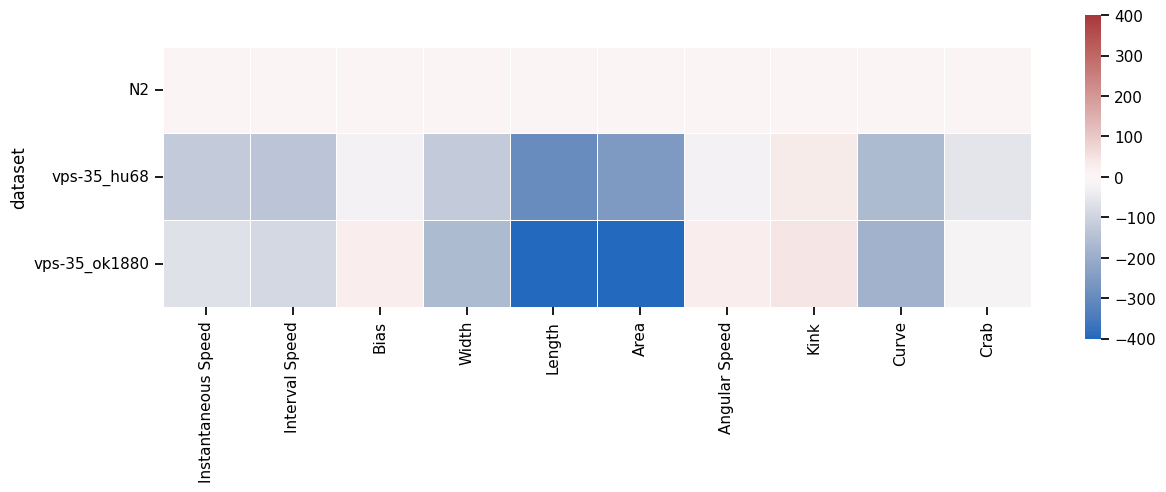

In [23]:
sns.set_context('notebook')
plt.figure(figsize=(14,14))
ax = sns.heatmap(data = PD_baseline_Tstats_sort, 
                 annot=False, 
                 linewidth=0.5, 
                 square=True, 
                 cmap="vlag", 
                 center=0, 
                 vmax=400,
                 vmin=-400, 
                 xticklabels=1,
                 yticklabels=1,
                 cbar_kws={"shrink": .3})
# plt.savefig(f'{StrainName}_Speed_{ISI}ISI.png_ByPlate', format='png', dpi=450)
plt.show()

### T-Test Analysis for Tap Data

In [34]:
PD_tap=Tap_Data
PD_tap[['Gene', 'Allele']] = PD_tap['dataset'].str.split('_', expand=True)
PD_tap['Allele']=PD_tap['Allele'].fillna('N2')
print(PD_tap)
PD_first_tap = PD_tap[(PD_tap.taps==1)].reset_index().drop(columns="index")
PD_last_three_taps = PD_tap[((PD_tap.taps>=28)&(PD_tap.taps<=30))].reset_index().drop(columns="index")
PD_recov_taps = PD_tap[(PD_tap.taps==31)].reset_index().drop(columns="index")
print(PD_first_tap)
print(PD_last_three_taps)
print(PD_recov_taps)

         time  dura   dist      prob     speed  plate taps        dataset  \
0     599.979  2.58  0.762  0.933333  0.295349      1    1             N2   
1     609.980  2.88  0.883  0.812500  0.306597      1    2             N2   
2     619.967  2.42  0.831  0.777778  0.343388      1    3             N2   
3     629.971  1.87  0.589  0.722222  0.314973      1    4             N2   
4     639.987  1.31  0.350  0.444444  0.267176      1    5             N2   
..        ...   ...    ...       ...       ...    ...  ...            ...   
118   859.998  0.84  0.126  0.475000  0.150000      4   27  vps-35_ok1880   
119   869.998  1.04  0.178  0.511628  0.171154      4   28  vps-35_ok1880   
120   879.998  0.85  0.133  0.204545  0.156471      4   29  vps-35_ok1880   
121   889.959  0.91  0.124  0.444444  0.136264      4   30  vps-35_ok1880   
122  1189.954  3.37  0.623  0.690476  0.184866      4   31  vps-35_ok1880   

       Gene  Allele  
0        N2      N2  
1        N2      N2  
2        

In [35]:
PD_final_taps=PD_last_three_taps.groupby(["dataset", "plate"]).mean().reset_index()
print(PD_final_taps)
# print(PD_first_tap)
# print(PD_recov_taps)

          dataset  plate        time      dura      dist      prob     speed
0              N2      1  879.981000  0.510000  0.119000  0.254407  0.213063
1              N2      2  879.975333  1.296667  0.322000  0.334407  0.237288
2              N2      3  879.948667  0.646667  0.115000  0.119940  0.173042
3              N2      4  879.963667  0.656667  0.128000  0.273301  0.193251
4              N2      5  879.966000  0.590000  0.134000  0.403109  0.220629
5              N2      6  879.966667  0.840000  0.160000  0.320346  0.189176
6              N2      7  879.963000  1.270000  0.267333  0.193676  0.195851
7              N2      8  879.901000  0.946667  0.183000  0.266210  0.194452
8     vps-35_hu68      1  879.927667  1.363333  0.168333  0.364490  0.123242
9     vps-35_hu68      2  879.972667  1.350000  0.237000  0.491591  0.175813
10    vps-35_hu68      3  879.982333  0.830000  0.139333  0.454265  0.170346
11    vps-35_hu68      4  879.976667  1.213333  0.230000  0.536737  0.188467

In [36]:
PD_final_taps=PD_final_taps.rename(columns={"dura": "final_dura", "prob": "final_prob", "speed": "final_speed"}, errors="raise")
PD_first_tap=PD_first_tap.rename(columns={"dura": "init_dura", "prob": "init_prob", "speed": "init_speed"}, errors="raise")
print(PD_final_taps)
print(PD_first_tap)

          dataset  plate        time  final_dura      dist  final_prob  \
0              N2      1  879.981000    0.510000  0.119000    0.254407   
1              N2      2  879.975333    1.296667  0.322000    0.334407   
2              N2      3  879.948667    0.646667  0.115000    0.119940   
3              N2      4  879.963667    0.656667  0.128000    0.273301   
4              N2      5  879.966000    0.590000  0.134000    0.403109   
5              N2      6  879.966667    0.840000  0.160000    0.320346   
6              N2      7  879.963000    1.270000  0.267333    0.193676   
7              N2      8  879.901000    0.946667  0.183000    0.266210   
8     vps-35_hu68      1  879.927667    1.363333  0.168333    0.364490   
9     vps-35_hu68      2  879.972667    1.350000  0.237000    0.491591   
10    vps-35_hu68      3  879.982333    0.830000  0.139333    0.454265   
11    vps-35_hu68      4  879.976667    1.213333  0.230000    0.536737   
12  vps-35_ok1880      1  879.957667  

In [48]:
PD_habit_levels = pd.merge(PD_first_tap, PD_final_taps, on =['dataset','plate'], how ='left')
PD_habit_levels = PD_habit_levels.dropna()
print(PD_habit_levels)

     time_x  init_dura  dist_x  init_prob  init_speed  plate taps  \
0   599.979       2.58   0.762   0.933333    0.295349      1    1   
1   599.981       2.69   0.613   1.000000    0.227881      2    1   
2   599.965       2.95   0.568   0.738095    0.192542      3    1   
3   599.988       2.24   0.588   0.837838    0.262500      4    1   
4   599.970       3.17   1.054   0.818182    0.332492      5    1   
5   599.987       3.10   0.866   0.733333    0.279355      6    1   
6   599.991       2.55   0.602   0.800000    0.236078      7    1   
7   599.904       2.17   0.541   0.825000    0.249309      8    1   
8   599.971       2.78   0.472   0.711111    0.169784      1    1   
9   599.960       4.24   0.778   0.666667    0.183491      2    1   
10  599.978       2.54   0.456   0.586207    0.179528      3    1   
11  599.993       2.98   0.477   0.697674    0.160067      4    1   
12  599.970       2.97   0.588   0.724138    0.197980      1    1   
13  599.982       3.04   0.654   0

In [49]:
PD_habit_levels['habit_dura']=PD_habit_levels.init_dura-PD_habit_levels.final_dura
PD_habit_levels['habit_prob']=PD_habit_levels.init_prob-PD_habit_levels.final_prob
PD_habit_levels['habit_speed']=PD_habit_levels.init_speed-PD_habit_levels.final_speed
PD_habit_levels=PD_habit_levels.drop(columns=['time_x','time_y','dist_x','dist_y', 'Allele','Gene'])

In [50]:
PD_recov_taps=PD_recov_taps.rename(columns={"dura": "recov_dura", "prob": "recov_prob", "speed":"recov_speed"})
PD_habituation = pd.merge(PD_habit_levels, PD_recov_taps, on =['dataset','plate'], how ='left')
PD_habituation = PD_habituation.drop(columns=['taps_x','taps_y'])
PD_habituation = PD_habituation.dropna()
print(PD_habituation)

    init_dura  init_prob  init_speed  plate        dataset  final_dura  \
0        2.58   0.933333    0.295349      1             N2    0.510000   
1        2.69   1.000000    0.227881      2             N2    1.296667   
2        2.95   0.738095    0.192542      3             N2    0.646667   
3        2.24   0.837838    0.262500      4             N2    0.656667   
4        3.17   0.818182    0.332492      5             N2    0.590000   
5        3.10   0.733333    0.279355      6             N2    0.840000   
6        2.55   0.800000    0.236078      7             N2    1.270000   
7        2.17   0.825000    0.249309      8             N2    0.946667   
8        2.78   0.711111    0.169784      1    vps-35_hu68    1.363333   
9        4.24   0.666667    0.183491      2    vps-35_hu68    1.350000   
10       2.54   0.586207    0.179528      3    vps-35_hu68    0.830000   
11       2.98   0.697674    0.160067      4    vps-35_hu68    1.213333   
12       2.97   0.724138    0.197980  

In [51]:
PD_habituation['recovery_dura']=PD_habituation.init_dura-PD_habituation.recov_dura
PD_habituation['recovery_prob']=PD_habituation.init_prob-PD_habituation.recov_prob
PD_habituation['recovery_speed']=PD_habituation.init_speed-PD_habituation.recov_speed
PD_habituation=PD_habituation.dropna()
print(PD_habituation)

    init_dura  init_prob  init_speed  plate        dataset  final_dura  \
0        2.58   0.933333    0.295349      1             N2    0.510000   
1        2.69   1.000000    0.227881      2             N2    1.296667   
2        2.95   0.738095    0.192542      3             N2    0.646667   
3        2.24   0.837838    0.262500      4             N2    0.656667   
4        3.17   0.818182    0.332492      5             N2    0.590000   
5        3.10   0.733333    0.279355      6             N2    0.840000   
6        2.55   0.800000    0.236078      7             N2    1.270000   
7        2.17   0.825000    0.249309      8             N2    0.946667   
8        2.78   0.711111    0.169784      1    vps-35_hu68    1.363333   
9        4.24   0.666667    0.183491      2    vps-35_hu68    1.350000   
10       2.54   0.586207    0.179528      3    vps-35_hu68    0.830000   
11       2.98   0.697674    0.160067      4    vps-35_hu68    1.213333   
12       2.97   0.724138    0.197980  

In [52]:
PD_recovery_dura=pd.DataFrame(columns = ["dataset","Recovery Duration"])
PD_recovery_prob=pd.DataFrame(columns = ["dataset","Recovery Probability"])
PD_recovery_speed=pd.DataFrame(columns = ["dataset","Recovery Speed"])
PD_init_dura=pd.DataFrame(columns = ["dataset","Initial Duration"])
PD_init_prob=pd.DataFrame(columns = ["dataset","Initial Probability"])
PD_init_speed=pd.DataFrame(columns = ["dataset","Initial Speed"])
PD_final_dura=pd.DataFrame(columns = ["dataset","Final Duration"])
PD_final_prob=pd.DataFrame(columns = ["dataset","Final Probability"])
PD_final_speed=pd.DataFrame(columns = ["dataset","Final Speed"])
PD_hab_dura=pd.DataFrame(columns = ["dataset","Habituation of Duration"])
PD_hab_prob=pd.DataFrame(columns = ["dataset","Habituation of Probability"])
PD_hab_speed=pd.DataFrame(columns = ["dataset","Habituation of Speed"])
print('done')

done


In [53]:
print(PD_habituation["dataset"].unique())

['N2' 'vps-35_hu68' 'vps-35_ok1880']


In [54]:
TTest_New(PD_habituation["dataset"].unique(), "recovery_dura", PD_habituation, PD_recovery_dura)
TTest_New(PD_habituation["dataset"].unique(), "recovery_prob", PD_habituation, PD_recovery_prob)
TTest_New(PD_habituation["dataset"].unique(), "recovery_speed", PD_habituation, PD_recovery_speed)
TTest_New(PD_habituation["dataset"].unique(), "init_dura", PD_habituation, PD_init_dura)
TTest_New(PD_habituation["dataset"].unique(), "init_prob", PD_habituation, PD_init_prob)
TTest_New(PD_habituation["dataset"].unique(), "init_speed", PD_habituation, PD_init_speed)
TTest_New(PD_habituation["dataset"].unique(), "final_dura", PD_habituation, PD_final_dura)
TTest_New(PD_habituation["dataset"].unique(), "final_prob", PD_habituation, PD_final_prob)
TTest_New(PD_habituation["dataset"].unique(), "final_speed", PD_habituation, PD_final_speed)
TTest_New(PD_habituation["dataset"].unique(), "habit_dura", PD_habituation, PD_hab_dura)
TTest_New(PD_habituation["dataset"].unique(), "habit_prob", PD_habituation, PD_hab_prob)
TTest_New(PD_habituation["dataset"].unique(), "habit_speed", PD_habituation, PD_hab_speed)
print("done")

         dataset  Recovery Duration
0             N2           0.000000
1    vps-35_hu68          -2.957559
2  vps-35_ok1880           1.392769
         dataset  Recovery Probability
0             N2               0.00000
1    vps-35_hu68              -0.08970
2  vps-35_ok1880              -1.82678
         dataset  Recovery Speed
0             N2        0.000000
1    vps-35_hu68        1.031271
2  vps-35_ok1880        0.702518
         dataset  Initial Duration
0             N2          0.000000
1    vps-35_hu68          1.130561
2  vps-35_ok1880          2.615619
         dataset  Initial Probability
0             N2             0.000000
1    vps-35_hu68            -3.988177
2  vps-35_ok1880            -3.829486
         dataset  Initial Speed
0             N2       0.000000
1    vps-35_hu68      -5.323116
2  vps-35_ok1880      -3.581820
         dataset  Final Duration
0             N2        0.000000
1    vps-35_hu68        2.095651
2  vps-35_ok1880        0.987803
         dataset

In [55]:
PD_habituation_Tstats=PD_recovery_dura
PD_habituation_Tstats=PD_habituation_Tstats.join(PD_recovery_prob.iloc[:,1])
PD_habituation_Tstats=PD_habituation_Tstats.join(PD_recovery_speed.iloc[:,1])
PD_habituation_Tstats=PD_habituation_Tstats.join(PD_init_dura.iloc[:,1])
PD_habituation_Tstats=PD_habituation_Tstats.join(PD_init_prob.iloc[:,1])
PD_habituation_Tstats=PD_habituation_Tstats.join(PD_init_speed.iloc[:,1])
PD_habituation_Tstats=PD_habituation_Tstats.join(PD_final_dura.iloc[:,1])
PD_habituation_Tstats=PD_habituation_Tstats.join(PD_final_prob.iloc[:,1])
PD_habituation_Tstats=PD_habituation_Tstats.join(PD_final_speed.iloc[:,1])
PD_habituation_Tstats=PD_habituation_Tstats.join(PD_hab_dura.iloc[:,1])
PD_habituation_Tstats=PD_habituation_Tstats.join(PD_hab_prob.iloc[:,1])
PD_habituation_Tstats=PD_habituation_Tstats.join(PD_hab_speed.iloc[:,1])
PD_habituation_Tstats=PD_habituation_Tstats.dropna()                                        
print(PD_habituation_Tstats)

         dataset  Recovery Duration  Recovery Probability  Recovery Speed  \
0             N2           0.000000               0.00000        0.000000   
1    vps-35_hu68          -2.957559              -0.08970        1.031271   
2  vps-35_ok1880           1.392769              -1.82678        0.702518   

   Initial Duration  Initial Probability  Initial Speed  Final Duration  \
0          0.000000             0.000000       0.000000        0.000000   
1          1.130561            -3.988177      -5.323116        2.095651   
2          2.615619            -3.829486      -3.581820        0.987803   

   Final Probability  Final Speed  Habituation of Duration  \
0           0.000000     0.000000                 0.000000   
1           4.000004    -2.357117                 0.292003   
2           3.455395    -2.805509                 2.273830   

   Habituation of Probability  Habituation of Speed  
0                    0.000000              0.000000  
1                   -5.973723    

In [56]:
PD_habituation_Tstats=PD_habituation_Tstats.set_index("dataset")
print(PD_habituation_Tstats)

               Recovery Duration  Recovery Probability  Recovery Speed  \
dataset                                                                  
N2                      0.000000               0.00000        0.000000   
vps-35_hu68            -2.957559              -0.08970        1.031271   
vps-35_ok1880           1.392769              -1.82678        0.702518   

               Initial Duration  Initial Probability  Initial Speed  \
dataset                                                               
N2                     0.000000             0.000000       0.000000   
vps-35_hu68            1.130561            -3.988177      -5.323116   
vps-35_ok1880          2.615619            -3.829486      -3.581820   

               Final Duration  Final Probability  Final Speed  \
dataset                                                         
N2                   0.000000           0.000000     0.000000   
vps-35_hu68          2.095651           4.000004    -2.357117   
vps-35_ok1880

In [57]:
PD_habituation_Tstats_sorted=PD_habituation_Tstats.sort_index()
print(PD_habituation_Tstats_sorted)

               Recovery Duration  Recovery Probability  Recovery Speed  \
dataset                                                                  
N2                      0.000000               0.00000        0.000000   
vps-35_hu68            -2.957559              -0.08970        1.031271   
vps-35_ok1880           1.392769              -1.82678        0.702518   

               Initial Duration  Initial Probability  Initial Speed  \
dataset                                                               
N2                     0.000000             0.000000       0.000000   
vps-35_hu68            1.130561            -3.988177      -5.323116   
vps-35_ok1880          2.615619            -3.829486      -3.581820   

               Final Duration  Final Probability  Final Speed  \
dataset                                                         
N2                   0.000000           0.000000     0.000000   
vps-35_hu68          2.095651           4.000004    -2.357117   
vps-35_ok1880

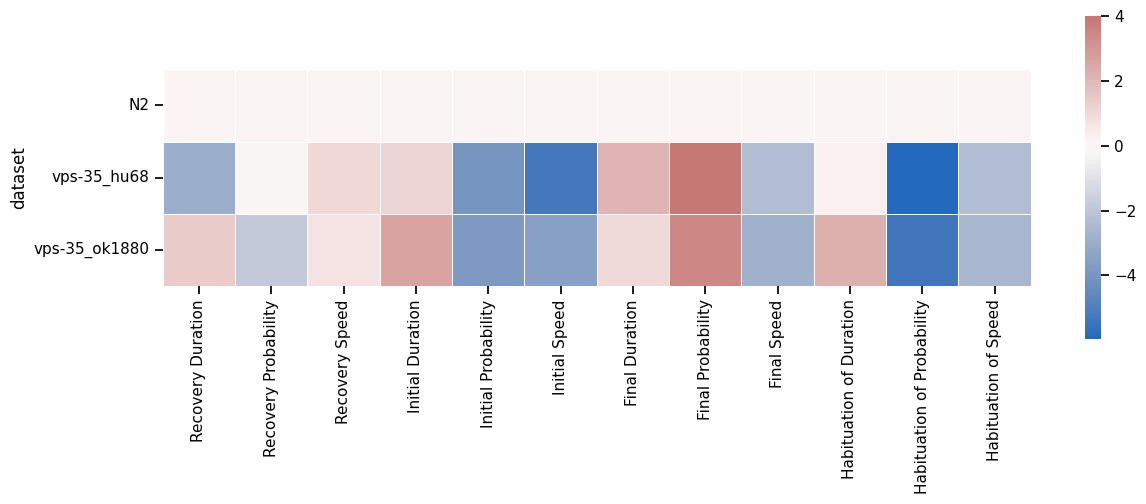

In [58]:
sns.set_context('notebook')
plt.figure(figsize=(14,14))
ax = sns.heatmap(data = PD_habituation_Tstats, 
                 annot=False, 
                 linewidth=0.5, 
                 square=True, 
                 cmap="vlag", 
                 center=0, 
#                  vmax=400,
#                  vmin=-400, 
                 xticklabels=1,
                 yticklabels=1,
                 cbar_kws={"shrink": .3})
# plt.savefig(f'{StrainName}_Speed_{ISI}ISI.png_ByPlate', format='png', dpi=450)
plt.show()

# Merging all T-test statistics from both data types together, and then graphinging a heatmap grouped by different alleles

In [59]:
PD_combined_Tstats = pd.merge(PD_baseline_Tstats, PD_habituation_Tstats, on =['dataset'], how ='left')
PD_combined_Tstats=PD_combined_Tstats.sort_index()
# PD_combined_Tstats=PD_combined_Tstats.drop(index="N2")
PD_combined_Tstats=PD_combined_Tstats.dropna()
PD_combined_Tstats_normalize=(PD_combined_Tstats-PD_combined_Tstats.mean())/PD_combined_Tstats.std()
print(PD_combined_Tstats_normalize)
print(PD_combined_Tstats_normalize.index)


               Instantaneous Speed  Interval Speed      Bias     Width  \
dataset                                                                  
N2                        1.039361        1.087549 -0.027777  1.116465   
vps-35_hu68              -0.955337       -0.879822 -0.985822 -0.303026   
vps-35_ok1880            -0.084024       -0.207727  1.013599 -0.813438   

                 Length      Area  Angular Speed      Kink     Curve  \
dataset                                                                
N2             1.084725  1.023966      -0.002432 -1.107466  1.146370   
vps-35_hu68   -0.199537 -0.049792      -0.998782  0.270644 -0.453283   
vps-35_ok1880 -0.885187 -0.974174       1.001214  0.836822 -0.693088   

                   Crab  ...  Recovery Speed  Initial Duration  \
dataset                  ...                                     
N2             0.883760  ...       -1.097050         -0.951913   
vps-35_hu68   -1.085484  ...        0.860551         -0.090078   
vps-

In [60]:
PD_combined_Tstats_normalize_2=PD_combined_Tstats_normalize-PD_combined_Tstats_normalize[PD_combined_Tstats_normalize.index=="N2"].squeeze()
print(PD_combined_Tstats_normalize_2[PD_combined_Tstats_normalize.index=="N2"])

         Instantaneous Speed  Interval Speed  Bias  Width  Length  Area  \
dataset                                                                   
N2                       0.0             0.0   0.0    0.0     0.0   0.0   

         Angular Speed  Kink  Curve  Crab  ...  Recovery Speed  \
dataset                                    ...                   
N2                 0.0   0.0    0.0   0.0  ...             0.0   

         Initial Duration  Initial Probability  Initial Speed  Final Duration  \
dataset                                                                         
N2                    0.0                  0.0            0.0             0.0   

         Final Probability  Final Speed  Habituation of Duration  \
dataset                                                            
N2                     0.0          0.0                      0.0   

         Habituation of Probability  Habituation of Speed  
dataset                                                    
N2    

In [62]:
# import matplotlib as mpl
# mpl.colors.rgb_to_hsv('255,215,0')
# 51
# 240

In [63]:
first_col=PD_combined_Tstats.pop("Area")
PD_combined_Tstats.insert(0,"Area",first_col)

first_col=PD_combined_Tstats.pop("Length")
PD_combined_Tstats.insert(0,"Length",first_col)

first_col=PD_combined_Tstats.pop("Width")
PD_combined_Tstats.insert(0,"Width",first_col)

first_col=PD_combined_Tstats_normalize_2.pop("Angular Speed")
PD_combined_Tstats_normalize_2.insert(5,"Angular Speed",first_col)

print(PD_combined_Tstats)

                    Width      Length        Area  Instantaneous Speed  \
dataset                                                                  
N2               0.000000    0.000000    0.000000             0.000000   
vps-35_hu68   -120.905476 -293.895206 -254.572296          -121.079388   
vps-35_ok1880 -164.379955 -450.801783 -473.729577           -68.190148   

               Interval Speed       Bias  Angular Speed       Kink  \
dataset                                                              
N2                   0.000000   0.000000       0.000000   0.000000   
vps-35_hu68       -135.689806 -25.672636     -27.080014  32.027399   
vps-35_ok1880      -89.335287  27.905649      27.278326  45.185444   

                    Curve       Crab  ...  Recovery Speed  Initial Duration  \
dataset                               ...                                     
N2               0.000000   0.000000  ...        0.000000          0.000000   
vps-35_hu68   -162.565440 -58.815057  ...

In [64]:
PD_combined_Tstats=PD_combined_Tstats.rename(columns={"Habituation of Duration":"Habituation of Response Duration",
                                                     "Habituation of Probability": "Habituation of Respones Probability",
                                                     "Habituation of Speed":"Habituation of Response Speed",
                                                     "Initial Duration": "Initial Response Duration",
                                                     "Initial Probability": "Initial Response Probability",
                                                     "Initial Speed": "Initial Response Speed",
                                                     "Final Duration": "Final Response Duration",
                                                     "Final Probability": "Final Response Probability",
                                                     "Final Speed": "Final Response Speed",
                                                     "Recovery Duration": "Spontaneous Recovery of Response Duration",
                                                     "Recovery Probability": "Spontaneous Recovery of Response Probability",
                                                     "Recovery Speed": "Spontaneous Recovery of Response Speed"})
PD_combined_Tstats.to_csv('CombinedTSTATData.csv')

In [65]:
PD_combined_Tstats_normalize_2=PD_combined_Tstats_normalize_2.rename(columns={"Habituation of Duration":"Habituation of Response Duration",
                                                                             "Habituation of Probability": "Habituation of Respones Probability",
                                                                             "Habituation of Speed":"Habituation of Response Speed",
                                                                             "Initial Duration": "Initial Response Duration",
                                                                             "Initial Probability": "Initial Response Probability",
                                                                             "Initial Speed": "Initial Response Speed",
                                                                             "Final Duration": "Final Response Duration",
                                                                             "Final Probability": "Final Response Probability",
                                                                             "Final Speed": "Final Response Speed",
                                                                             "Recovery Duration": "Spontaneous Recovery of Response Duration",
                                                                             "Recovery Probability": "Spontaneous Recovery of Response Probability",
                                                                             "Recovery Speed": "Spontaneous Recovery of Response Speed"})
print(PD_combined_Tstats_normalize_2)

               Instantaneous Speed  Interval Speed      Bias     Width  \
dataset                                                                  
N2                        0.000000        0.000000  0.000000  0.000000   
vps-35_hu68              -1.994698       -1.967371 -0.958045 -1.419491   
vps-35_ok1880            -1.123385       -1.295275  1.041376 -1.929903   

                 Length  Angular Speed      Area      Kink     Curve  \
dataset                                                                
N2             0.000000       0.000000  0.000000  0.000000  0.000000   
vps-35_hu68   -1.284262      -0.996350 -1.073758  1.378109 -1.599653   
vps-35_ok1880 -1.969912       1.003646 -1.998140  1.944288 -1.839458   

                   Crab  ...  Spontaneous Recovery of Response Speed  \
dataset                  ...                                           
N2             0.000000  ...                                0.000000   
vps-35_hu68   -1.969244  ...                        

In [66]:
first_col=PD_combined_Tstats_normalize_2.pop("Area")
PD_combined_Tstats_normalize_2.insert(0,"Area",first_col)

first_col=PD_combined_Tstats_normalize_2.pop("Length")
PD_combined_Tstats_normalize_2.insert(0,"Length",first_col)

first_col=PD_combined_Tstats_normalize_2.pop("Width")
PD_combined_Tstats_normalize_2.insert(0,"Width",first_col)

first_col=PD_combined_Tstats_normalize_2.pop("Angular Speed")
PD_combined_Tstats_normalize_2.insert(5,"Angular Speed",first_col)

last_col=PD_combined_Tstats_normalize_2.pop("Spontaneous Recovery of Response Duration")
PD_combined_Tstats_normalize_2.insert(21,"Spontaneous Recovery of Response Duration",last_col)

last_col=PD_combined_Tstats_normalize_2.pop("Spontaneous Recovery of Response Probability")
PD_combined_Tstats_normalize_2.insert(21,"Spontaneous Recovery of Response Probability",last_col)

last_col=PD_combined_Tstats_normalize_2.pop("Spontaneous Recovery of Response Speed")
PD_combined_Tstats_normalize_2.insert(21,"Spontaneous Recovery of Response Speed",last_col)



print(PD_combined_Tstats_normalize_2)
PD_combined_Tstats_normalize_2.to_csv('Normalized_TSTATData.csv')

                  Width    Length      Area  Instantaneous Speed  \
dataset                                                            
N2             0.000000  0.000000  0.000000             0.000000   
vps-35_hu68   -1.419491 -1.284262 -1.073758            -1.994698   
vps-35_ok1880 -1.929903 -1.969912 -1.998140            -1.123385   

               Interval Speed  Angular Speed      Bias      Kink     Curve  \
dataset                                                                      
N2                   0.000000       0.000000  0.000000  0.000000  0.000000   
vps-35_hu68         -1.967371      -0.996350 -0.958045  1.378109 -1.599653   
vps-35_ok1880       -1.295275       1.003646  1.041376  1.944288 -1.839458   

                   Crab  ...  Initial Response Speed  Final Response Duration  \
dataset                  ...                                                    
N2             0.000000  ...                0.000000                 0.000000   
vps-35_hu68   -1.969244  

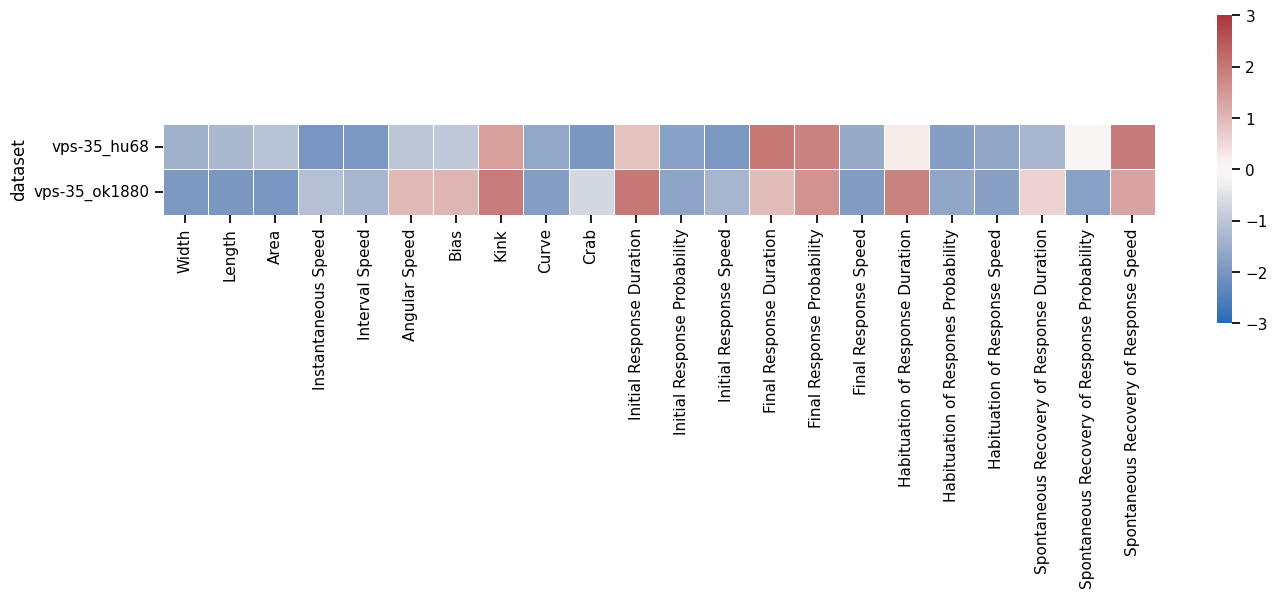

In [67]:
sns.set_context('notebook')
plt.figure(figsize=(16,20))
ax = sns.heatmap(data = PD_combined_Tstats_normalize_2.drop(index="N2"), 
                 annot=False, 
                 linewidth=0.5, 
                 square=True, 
                 cmap="vlag", 
#                  cmap=sns.diverging_palette(55, 250, s=100, l=40,as_cmap=True), 
                 center=0, 
                 vmax=3,
                 vmin=-3, 
                 xticklabels=1,
                 yticklabels=1,
                 cbar_kws={"shrink": .2})
# plt.savefig('Tstat_Strain_normalized.png', format='png', dpi=450, bbox_inches = "tight")
plt.show()

# Now To Generate Metric-wise Plots

In [68]:
PD_combined_Tstats_melted=PD_combined_Tstats.reset_index()
PD_combined_Tstats_melted=pd.melt(PD_combined_Tstats_melted, id_vars=['dataset'],
                                   var_name='Metric',
                                   value_name='T_score')
PD_combined_Tstats_melted_sorted=PD_combined_Tstats_melted.sort_values(by=['T_score'])
# print(PD_gene_Tstats_melted_gene)
print(PD_combined_Tstats_melted_sorted)
# PD_gene_Tstats_melted_metric=pd.melt(PD_gene_Tstats_melted_gene, id_vars=['dataset'],
#                              value_name='metric')


PD_combined_normalized_Tstats_melted=PD_combined_Tstats_normalize_2.reset_index()
PD_combined_normalized_Tstats_melted=pd.melt(PD_combined_normalized_Tstats_melted, id_vars=['dataset'],
                                   var_name='Metric',
                                   value_name='T_score')
PD_combined_normalized_Tstats_melted_sorted=PD_combined_normalized_Tstats_melted.sort_values(by=['Metric'])

          dataset                      Metric     T_score
8   vps-35_ok1880                        Area -473.729577
5   vps-35_ok1880                      Length -450.801783
4     vps-35_hu68                      Length -293.895206
7     vps-35_hu68                        Area -254.572296
26  vps-35_ok1880                       Curve -186.935724
..            ...                         ...         ...
52    vps-35_hu68  Final Response Probability    4.000004
20  vps-35_ok1880               Angular Speed   27.278326
17  vps-35_ok1880                        Bias   27.905649
22    vps-35_hu68                        Kink   32.027399
23  vps-35_ok1880                        Kink   45.185444

[66 rows x 3 columns]


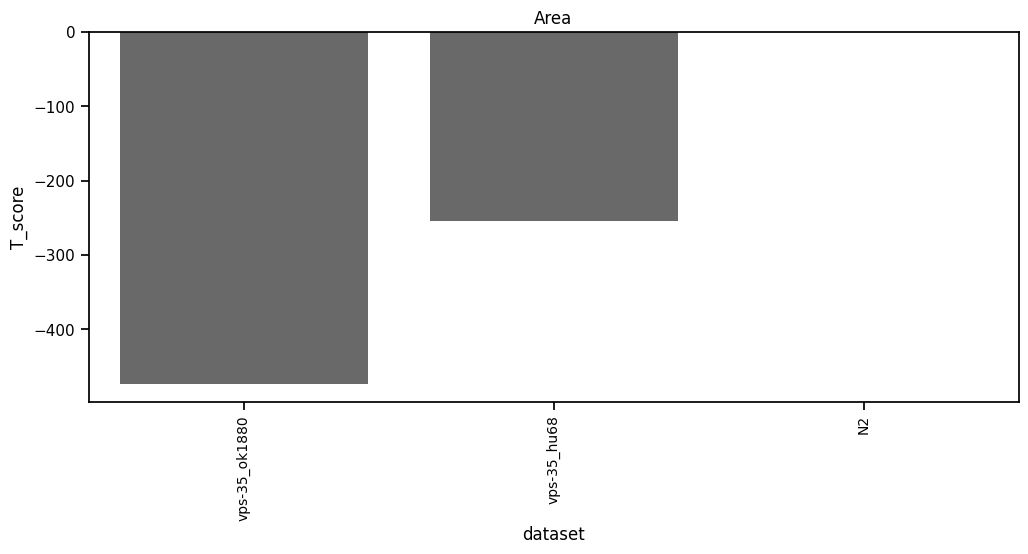

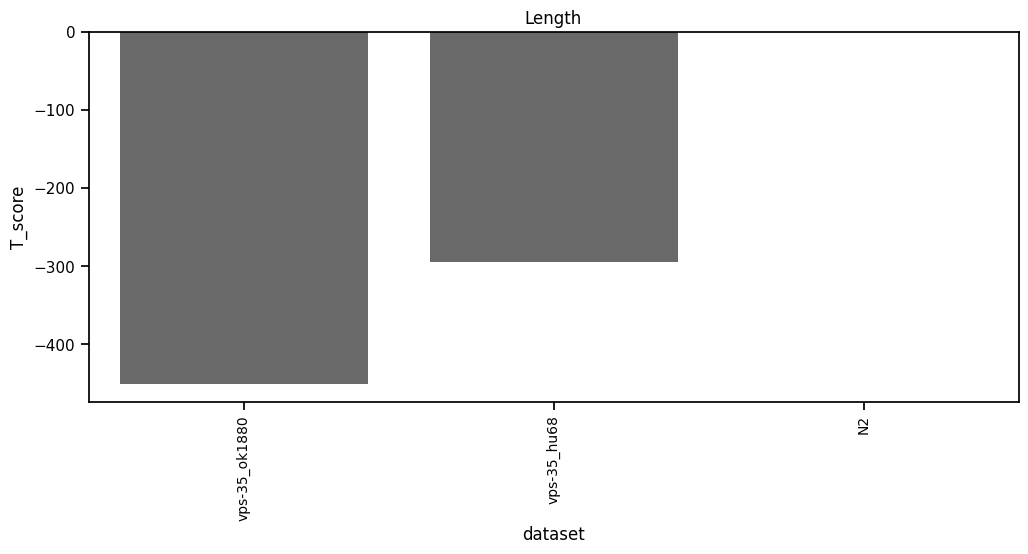

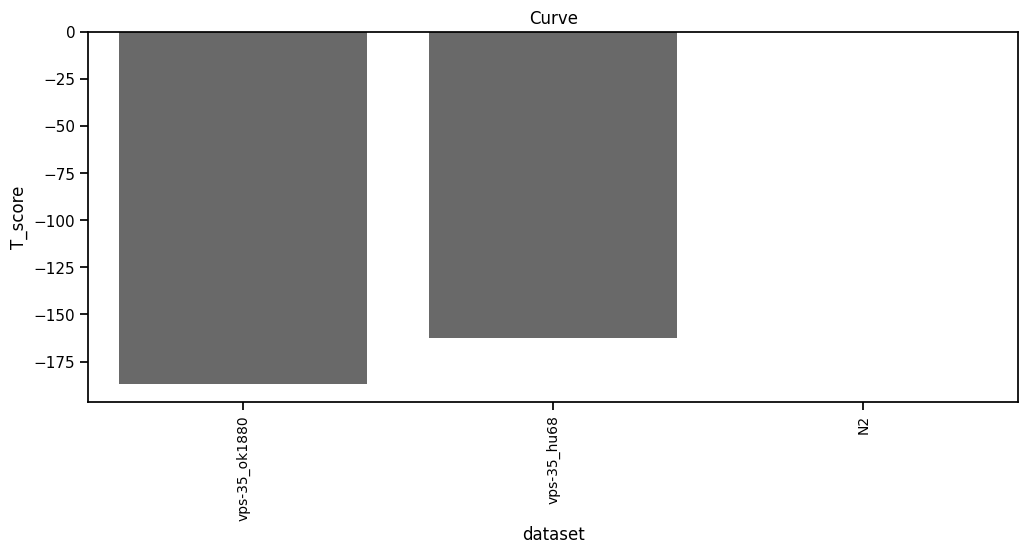

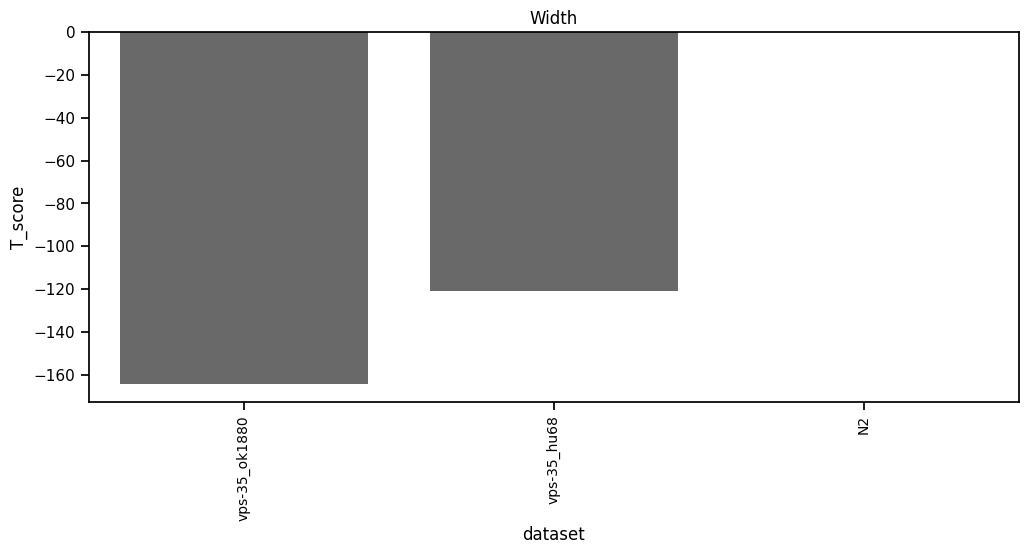

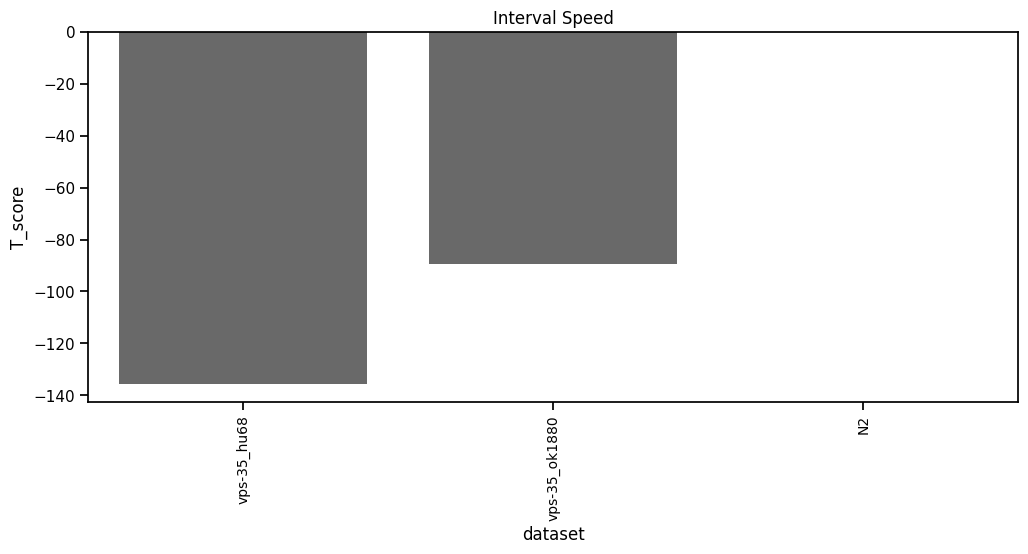

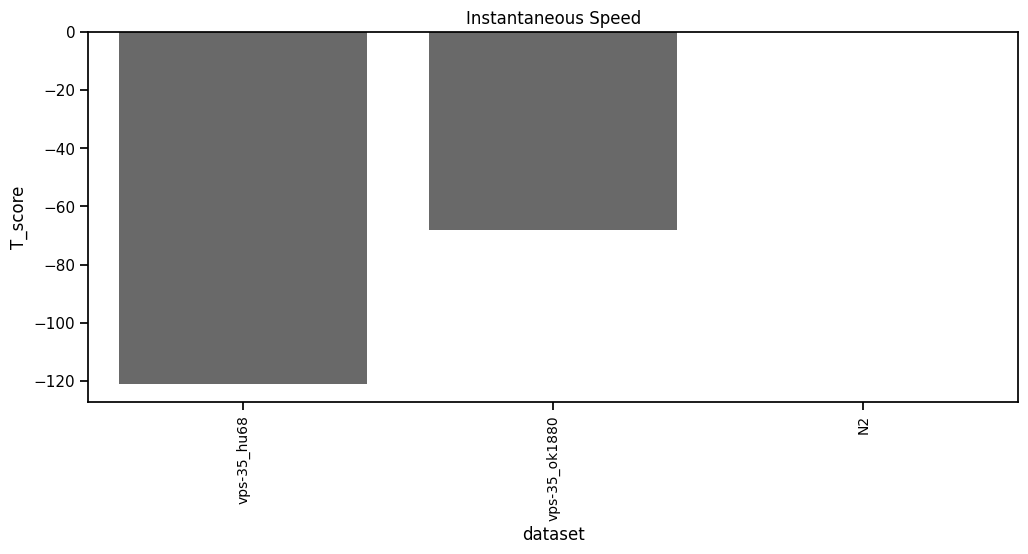

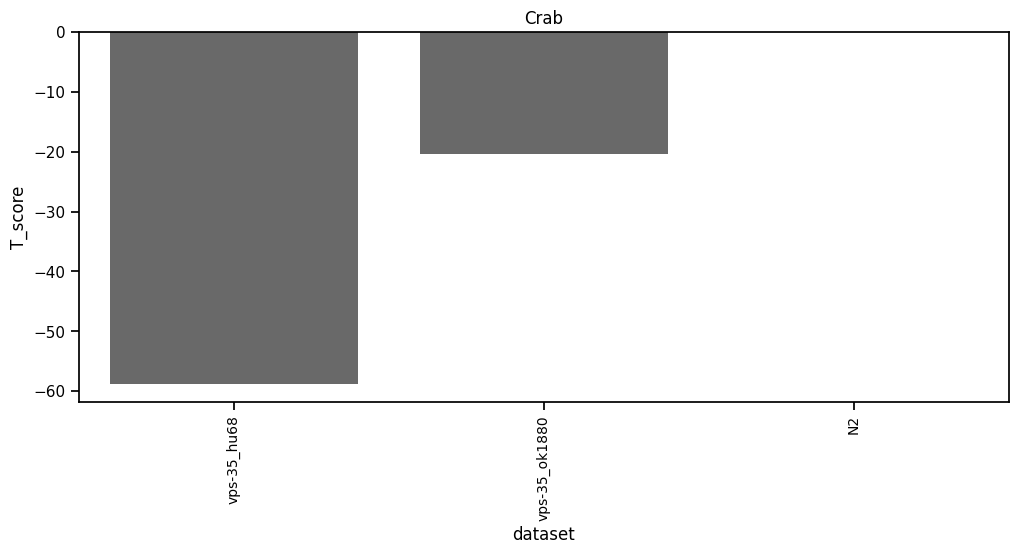

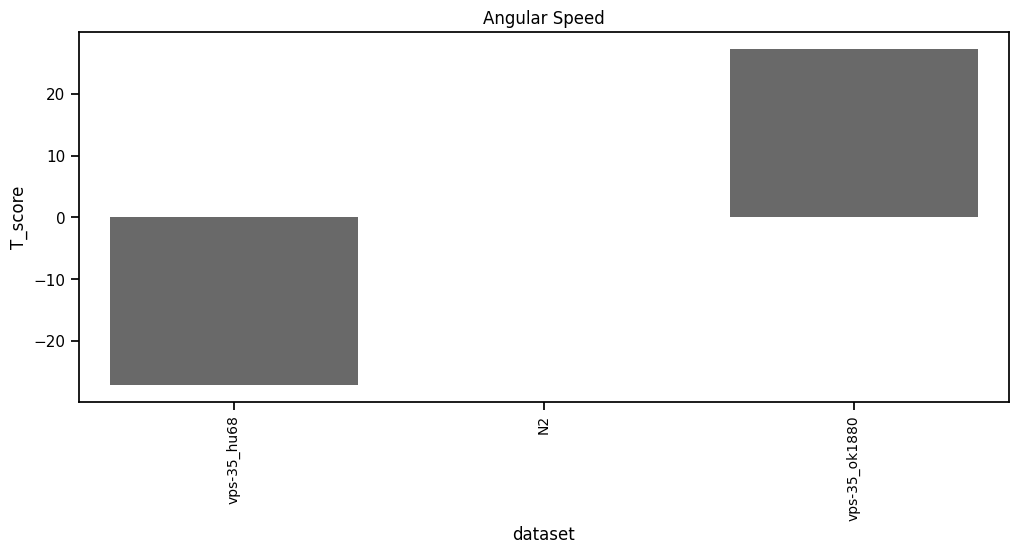

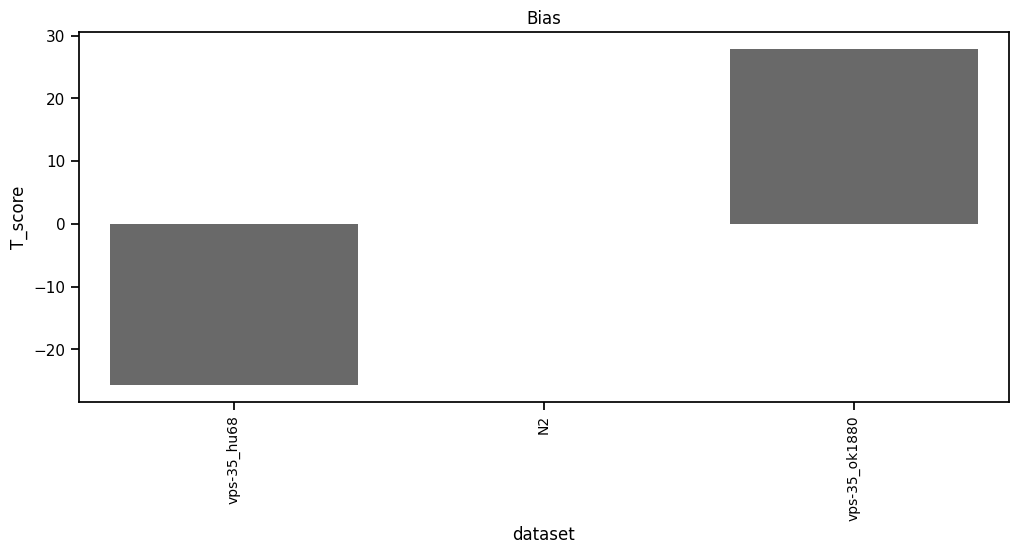

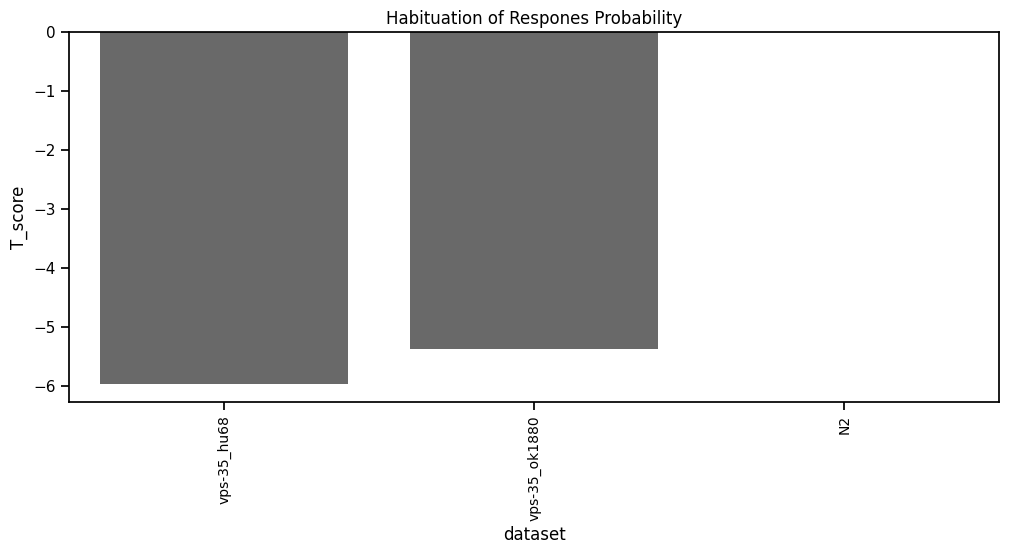

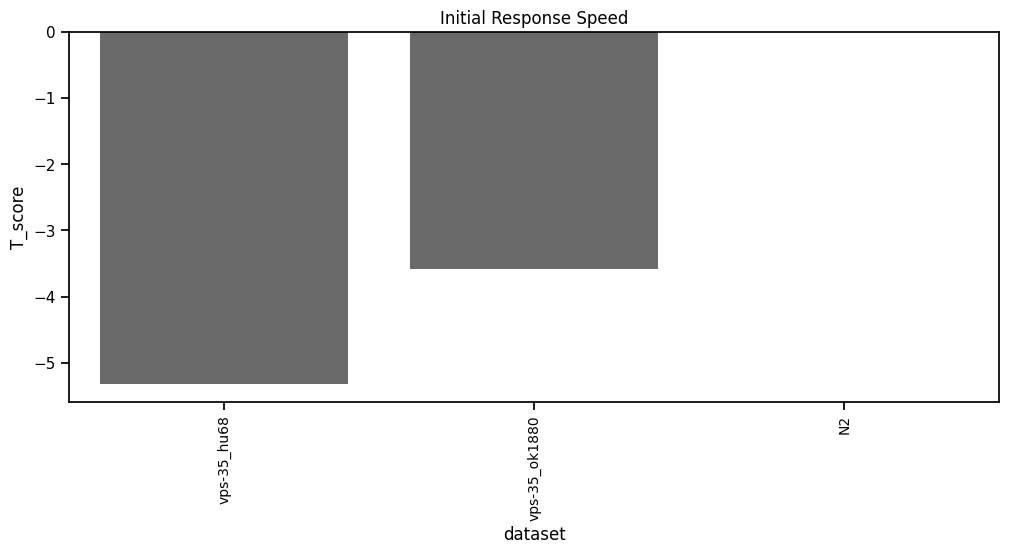

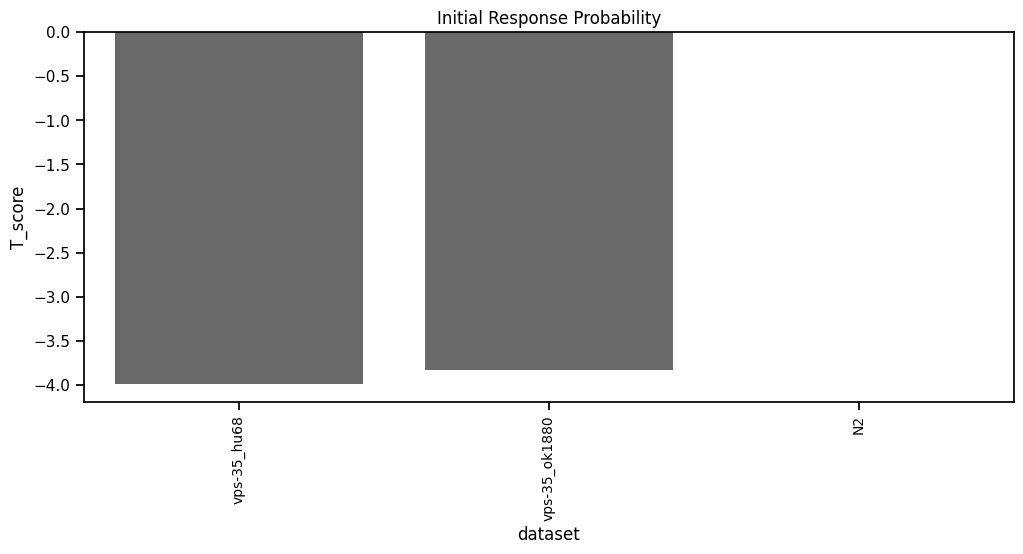

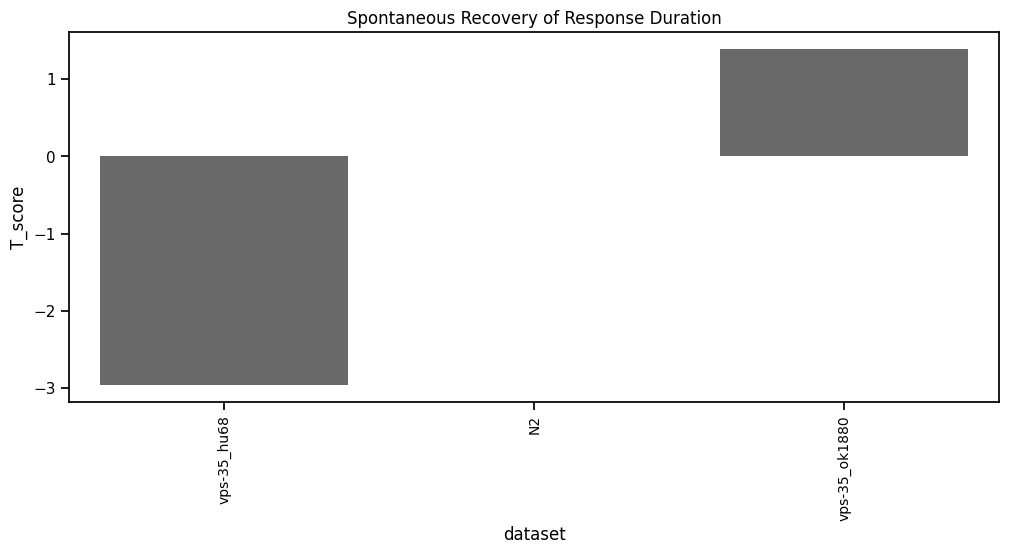

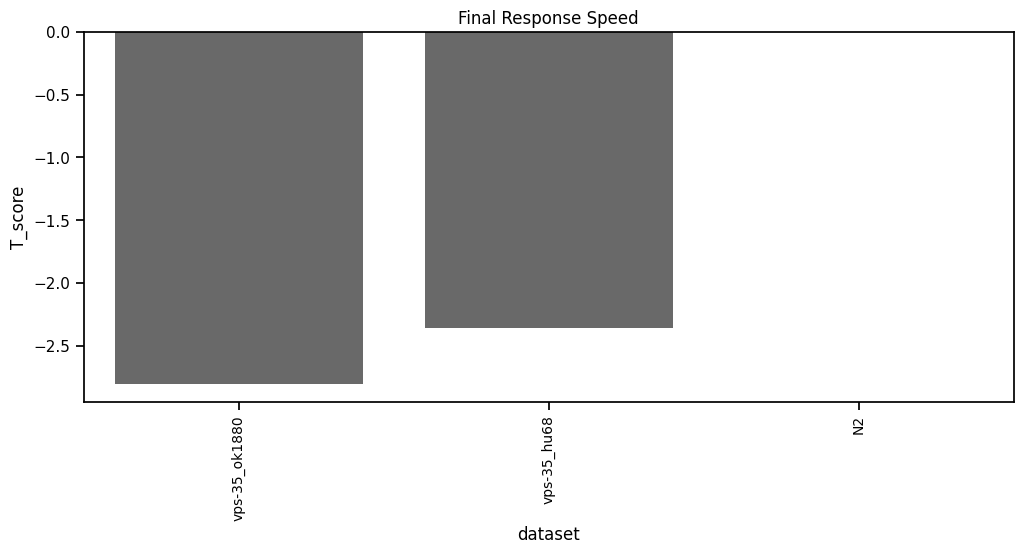

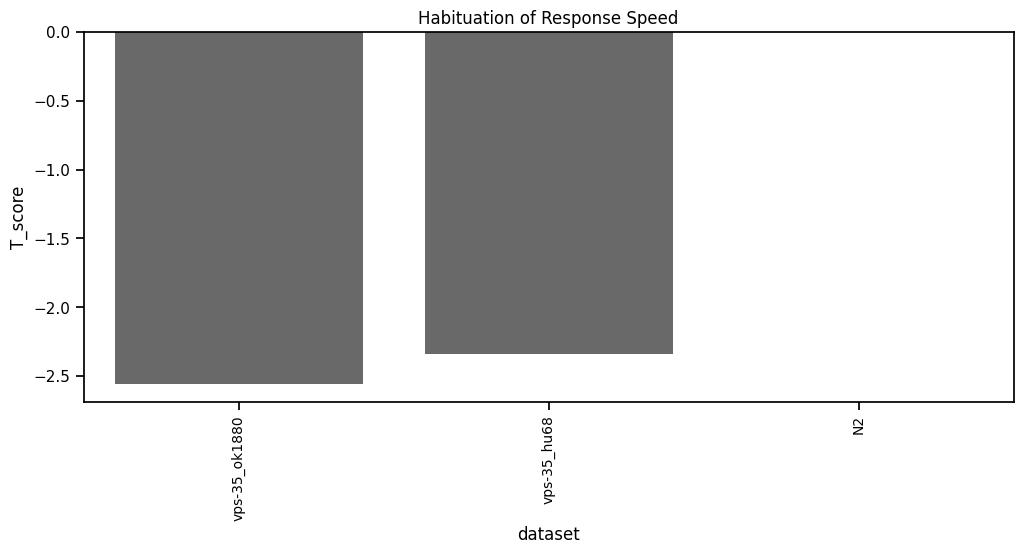

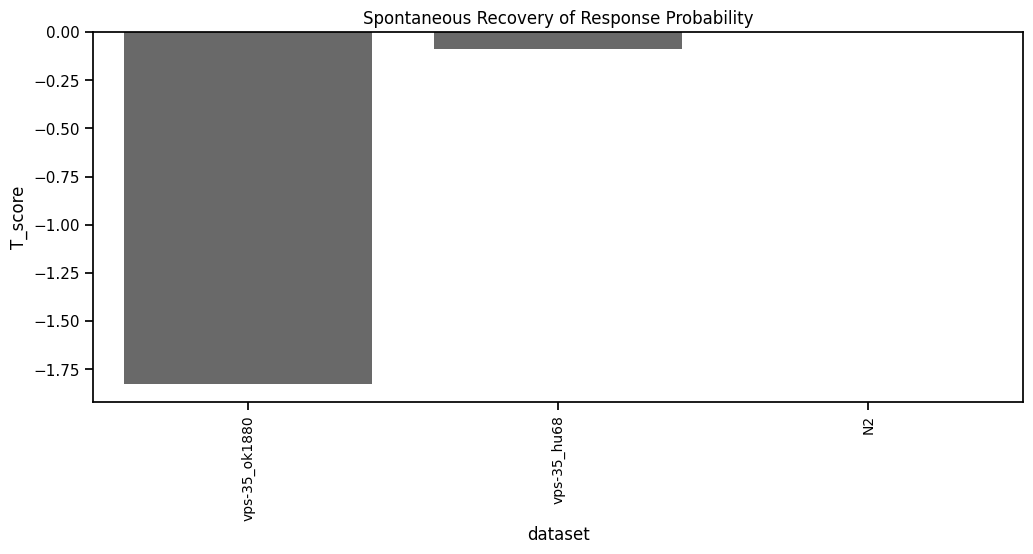

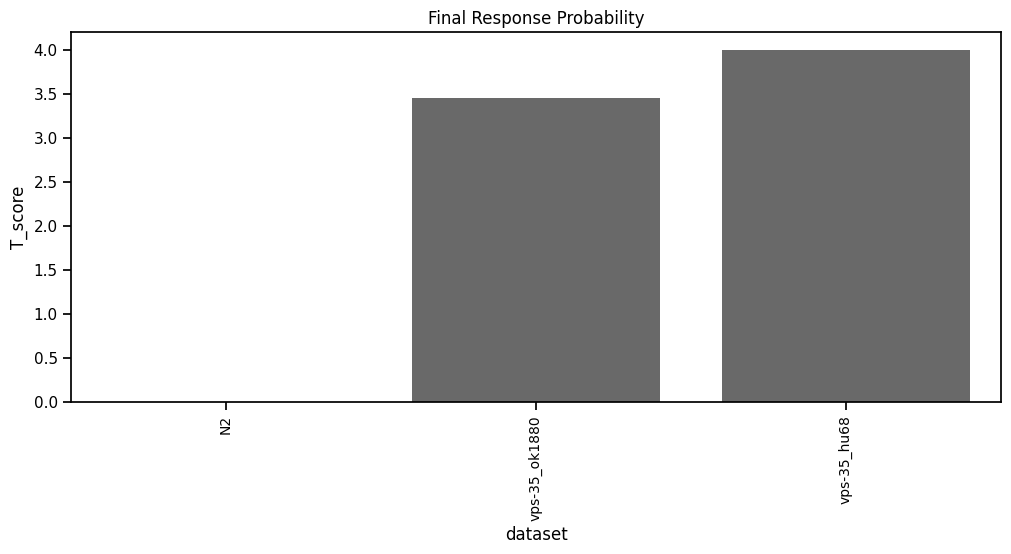

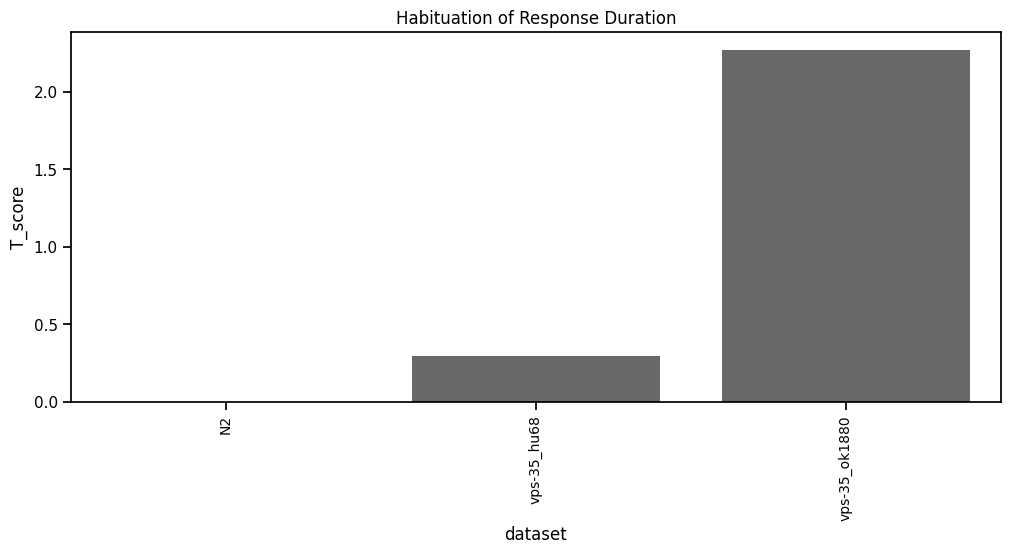

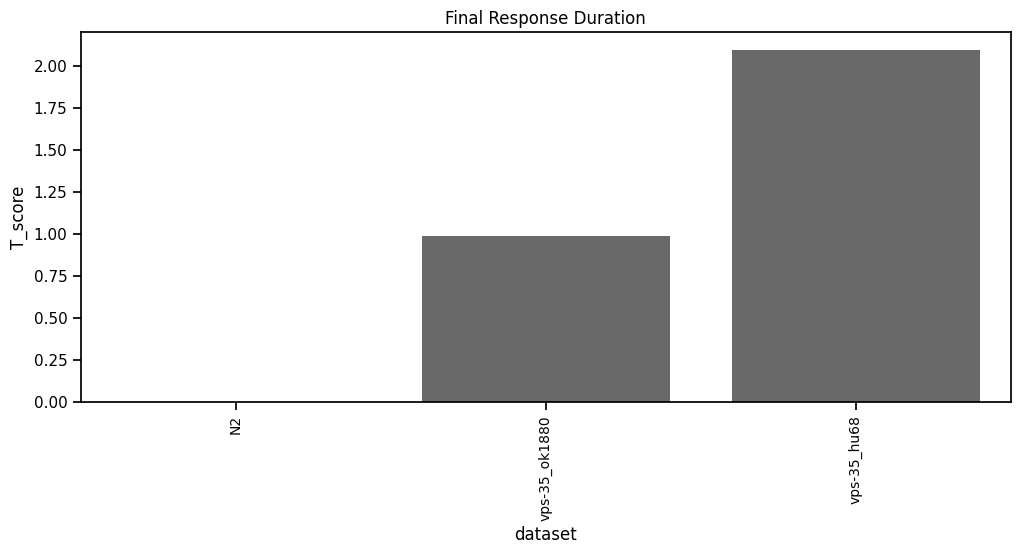

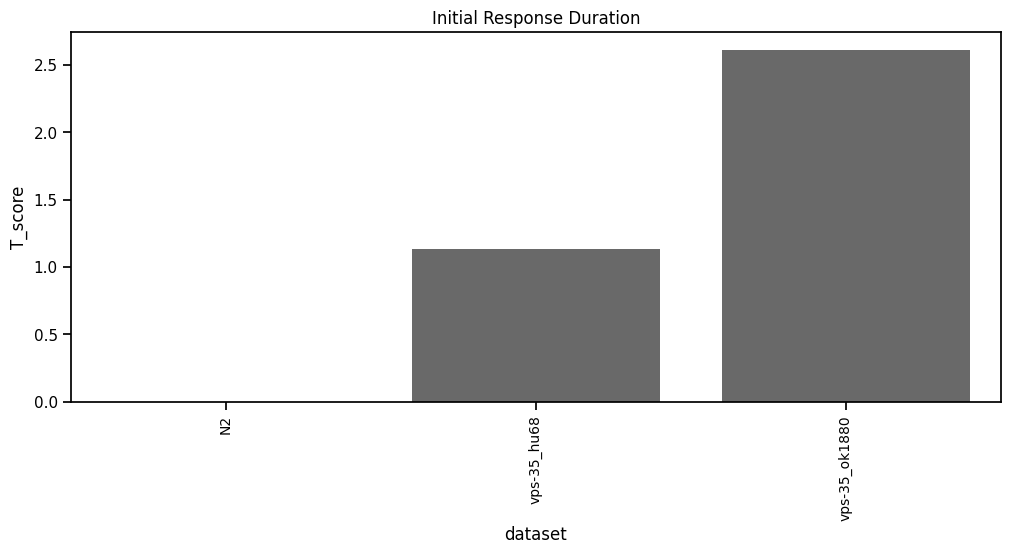

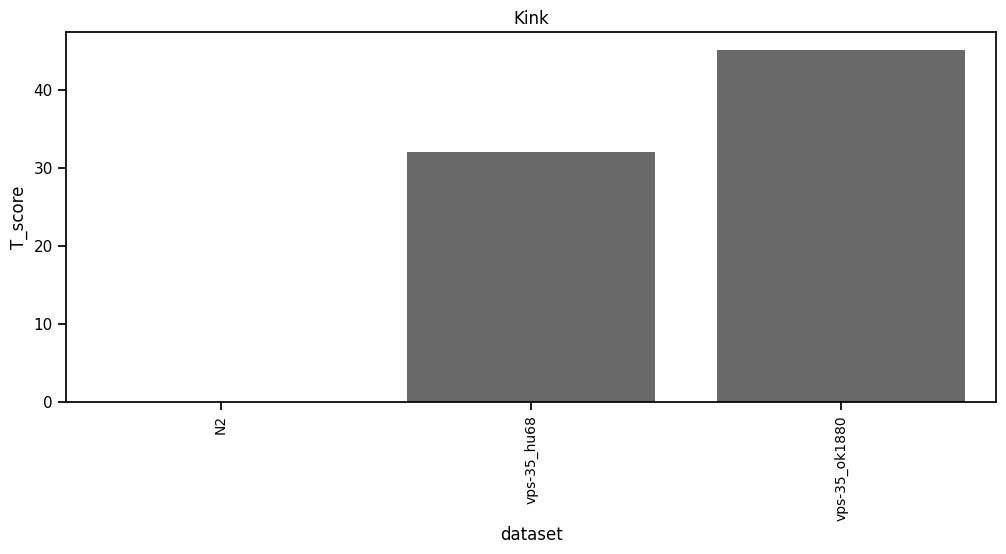

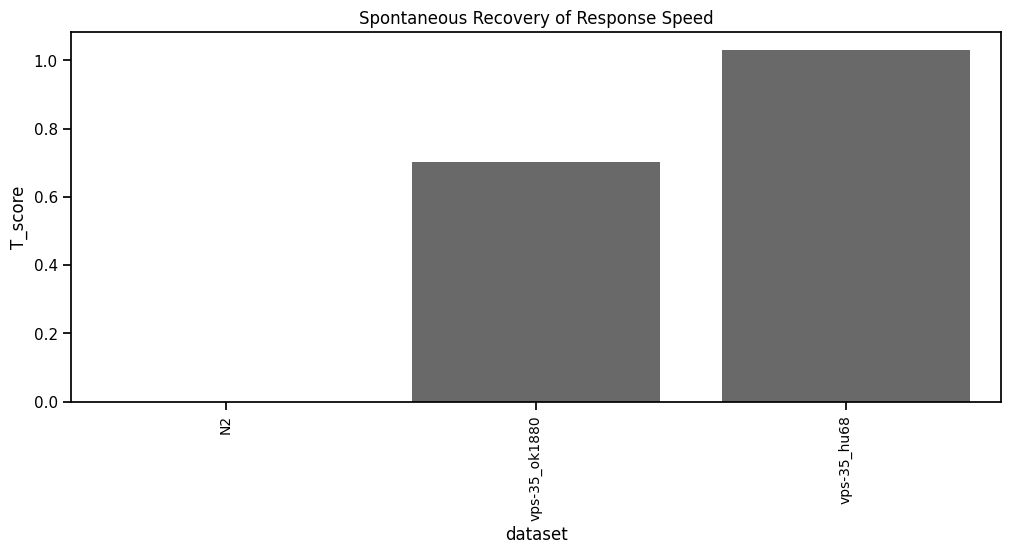

done


In [69]:
for x in PD_combined_Tstats_melted_sorted.Metric.unique():
    plt.figure(figsize=(12,4.8))
    ax = sns.barplot(data = PD_combined_Tstats_melted_sorted[PD_combined_Tstats_melted_sorted.Metric==f"{x}"], 
                x="dataset",
                y="T_score",
                palette=["dimgray"]).set_title(f"{x}")
    plt.xticks(rotation=90)
    plt.tick_params(axis='x', which='major', labelsize=10)
#     plt.ylim(-3,3)
    # plt.savefig(f'{x}_Metrics.png', format='png', dpi=450, bbox_inches = "tight")
    plt.show()
print("done")

In [ ]:
print(PD_combined_normalized_Tstats_melted_sorted)

# Now To Generate Allelic Phenotypic Profiles

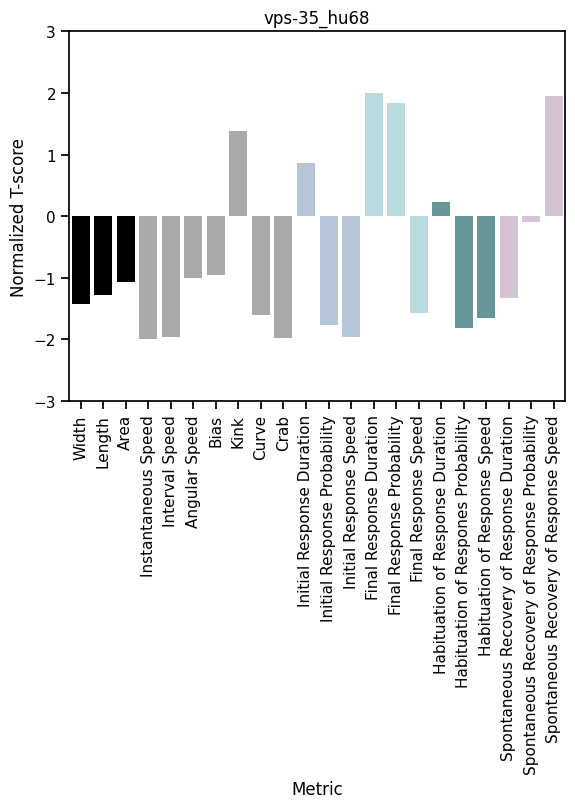

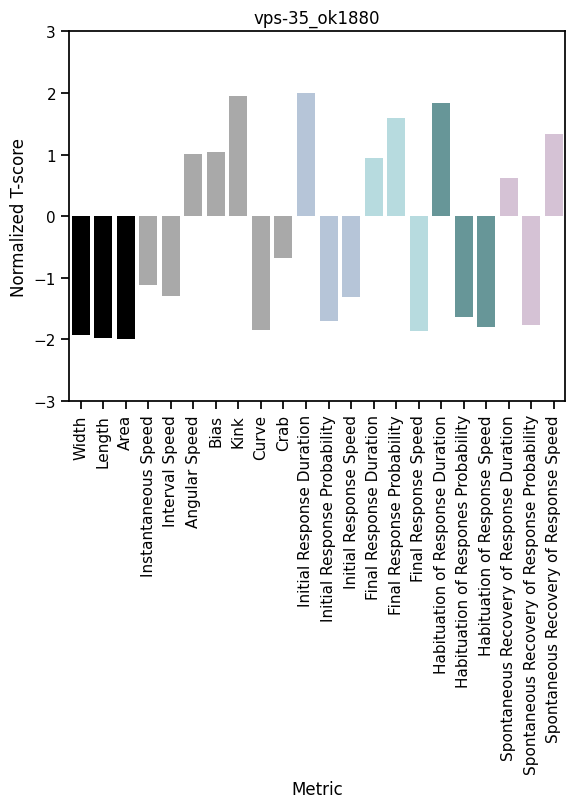

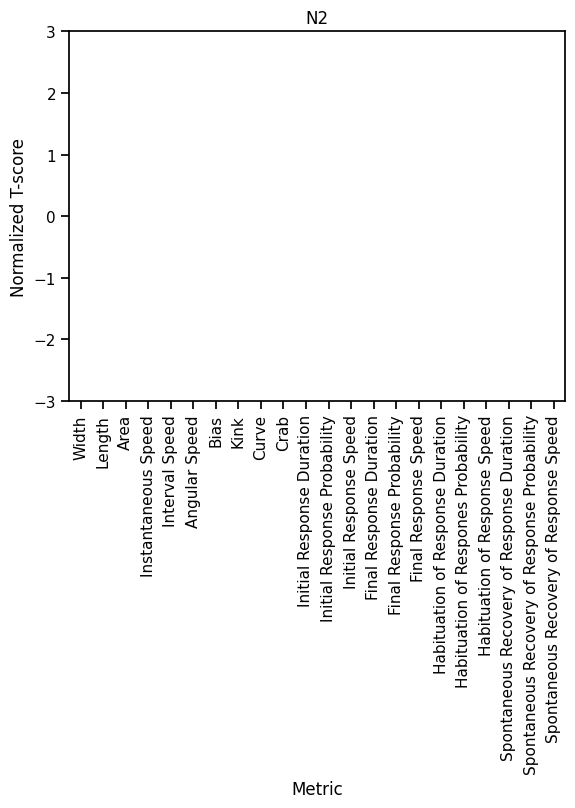

done


In [70]:
metric_palette=["k","k","k",
                "darkgray","darkgray","darkgray","darkgray","darkgray","darkgray","darkgray",
                "lightsteelblue","lightsteelblue","lightsteelblue",
                "powderblue","powderblue","powderblue",
                "cadetblue","cadetblue","cadetblue",
                "thistle","thistle","thistle"]

sns.set_context('notebook')
for x in PD_combined_normalized_Tstats_melted_sorted.dataset.unique():
    plt.figure()
    ax = sns.barplot(data = PD_combined_normalized_Tstats_melted[PD_combined_normalized_Tstats_melted.dataset==f"{x}"], 
                x="Metric",
                y="T_score",
                palette=metric_palette).set_title(f"{x}")
    plt.ylim(-3,3)
    plt.xticks(rotation=90)
    plt.ylabel('Normalized T-score')
    # plt.savefig(f'{x}_Metrics.png', format='png', dpi=450, bbox_inches = "tight")
    plt.show()
print("done")

## T-stat Analysis By Gene (Combining the Alleles together)

In [71]:
PD_gene_baseline_width_T=pd.DataFrame(columns = ["dataset","Width"])
PD_gene_baseline_length_T=pd.DataFrame(columns = ["dataset","Length"])
PD_gene_baseline_area_T=pd.DataFrame(columns = ["dataset","Area"])
PD_gene_baseline_aspectratio_T=pd.DataFrame(columns = ["dataset","Aspect Ratio"])
PD_gene_baseline_instantspeed_T=pd.DataFrame(columns = ["dataset","Instantaneous Speed"])
PD_gene_baseline_intspeed_T=pd.DataFrame(columns = ["dataset","Interval Speed"])
PD_gene_baseline_angularspeed_T=pd.DataFrame(columns = ["dataset","Angular Speed"])
PD_gene_baseline_bias_T=pd.DataFrame(columns = ["dataset","Bias"])
PD_gene_baseline_kink_T=pd.DataFrame(columns = ["dataset","Kink"])
PD_gene_baseline_curve_T=pd.DataFrame(columns = ["dataset","Curve"])
PD_gene_baseline_crab_T=pd.DataFrame(columns = ["dataset","Crab"])


PD_gene_init_dura=pd.DataFrame(columns = ["dataset","Initial Response Duration"])
PD_gene_init_prob=pd.DataFrame(columns = ["dataset","Initial Response Probability"])
PD_gene_init_speed=pd.DataFrame(columns = ["dataset","Initial Response Speed"])
PD_gene_final_dura=pd.DataFrame(columns = ["dataset","Final Response Duration"])
PD_gene_final_prob=pd.DataFrame(columns = ["dataset","Final Response Probability"])
PD_gene_final_speed=pd.DataFrame(columns = ["dataset","Final Response Speed"])
PD_gene_hab_dura=pd.DataFrame(columns = ["dataset","Habituation of Response Duration"])
PD_gene_hab_prob=pd.DataFrame(columns = ["dataset","Habituation of Response Probability"])
PD_gene_hab_speed=pd.DataFrame(columns = ["dataset","Habituation of Response Speed"])
PD_gene_recovery_dura=pd.DataFrame(columns = ["dataset","Spontaneous Recovery of Response Duration"])
PD_gene_recovery_prob=pd.DataFrame(columns = ["dataset","Spontaneous Recovery of Response Probability"])
PD_gene_recovery_speed=pd.DataFrame(columns = ["dataset","Spontaneous Recovery of Response Speed"])

In [72]:
PD_baseline_last100=PD_baseline_last100.dropna()
print(PD_baseline_last100)

       index     Time   n  Number  Instantaneous Speed  Interval Speed   Bias  \
0      11619  490.004  30      18               0.0993          0.1008  0.412   
1      11620  490.047  30      18               0.1076          0.1138  0.412   
2      11621  490.090  30      18               0.1116          0.1163  0.412   
3      11622  490.131  30      18               0.1082          0.1245  0.412   
4      11623  490.172  30      18               0.1105          0.1285  0.412   
...      ...      ...  ..     ...                  ...             ...    ...   
28304  80223  589.643  75      47               0.0319          0.0326  0.261   
28305  80224  589.722  75      47               0.0263          0.0256  0.261   
28306  80225  589.795  75      47               0.0364          0.0350  0.283   
28307  80226  589.843  76      47               0.0448          0.0428  0.304   
28308  80227  589.924  76      47               0.0315          0.0339  0.304   

        Width  Length      

In [73]:
print(PD_baseline_last100.Gene.unique())
print(len(PD_baseline_last100.Gene.unique()))
type(PD_baseline_last100.Gene.unique()[1])

['N2' 'vps-35']
2


str

In [74]:
def TTest_Gene(DatasetList, Type, DF_ref, output):
    for a in DatasetList:
        Tstat=ttest_ind(DF_ref[DF_ref.Gene == a][Type], DF_ref[DF_ref.Gene == "N2"][Type],equal_var=False)[0]
        row=[a, Tstat]
        output.loc[len(output)]=row
    print(output)

In [75]:
# print(PD_habituation.Gene.unique())
# print(len(PD_habituation.Gene.unique()))
# print(PD_baseline_last100.Gene.unique())
# print(len(PD_baseline_last100.Gene.unique()))
PD_habituation=PD_habituation.dropna()

['N2' 'vps-35']
2
['N2' 'vps-35']
2


In [76]:
TTest_Gene(PD_baseline_last100.Gene.unique(), 'Instantaneous Speed', PD_baseline_last100, PD_gene_baseline_instantspeed_T)
TTest_Gene(PD_baseline_last100.Gene.unique(), "Interval Speed", PD_baseline_last100, PD_gene_baseline_intspeed_T)
TTest_Gene(PD_baseline_last100.Gene.unique(), "Bias", PD_baseline_last100, PD_gene_baseline_bias_T)
TTest_Gene(PD_baseline_last100.Gene.unique(), "Width", PD_baseline_last100, PD_gene_baseline_width_T)
TTest_Gene(PD_baseline_last100.Gene.unique(), "Length", PD_baseline_last100, PD_gene_baseline_length_T)
TTest_Gene(PD_baseline_last100.Gene.unique(), "Area", PD_baseline_last100, PD_gene_baseline_area_T)
TTest_Gene(PD_baseline_last100.Gene.unique(), "Angular Speed", PD_baseline_last100, PD_gene_baseline_angularspeed_T)
TTest_Gene(PD_baseline_last100.Gene.unique(), "Aspect Ratio", PD_baseline_last100, PD_gene_baseline_aspectratio_T)
TTest_Gene(PD_baseline_last100.Gene.unique(), "Kink", PD_baseline_last100, PD_gene_baseline_kink_T)
TTest_Gene(PD_baseline_last100.Gene.unique(), "Curve", PD_baseline_last100, PD_gene_baseline_curve_T)
TTest_Gene(PD_baseline_last100.Gene.unique(), "Crab", PD_baseline_last100, PD_gene_baseline_crab_T)

TTest_Gene(PD_habituation["Gene"].unique(), "recovery_dura", PD_habituation, PD_gene_recovery_dura)
TTest_Gene(PD_habituation["Gene"].unique(), "recovery_prob", PD_habituation, PD_gene_recovery_prob)
TTest_Gene(PD_habituation["Gene"].unique(), "recovery_speed", PD_habituation, PD_gene_recovery_speed)
TTest_Gene(PD_habituation["Gene"].unique(), "init_dura", PD_habituation, PD_gene_init_dura)
TTest_Gene(PD_habituation["Gene"].unique(), "init_prob", PD_habituation, PD_gene_init_prob)
TTest_Gene(PD_habituation["Gene"].unique(), "init_speed", PD_habituation, PD_gene_init_speed)
TTest_Gene(PD_habituation["Gene"].unique(), "final_dura", PD_habituation, PD_gene_final_dura)
TTest_Gene(PD_habituation["Gene"].unique(), "final_prob", PD_habituation, PD_gene_final_prob)
TTest_Gene(PD_habituation["Gene"].unique(), "final_speed", PD_habituation, PD_gene_final_speed)
TTest_Gene(PD_habituation["Gene"].unique(), "habit_dura", PD_habituation, PD_gene_hab_dura)
TTest_Gene(PD_habituation["Gene"].unique(), "habit_prob", PD_habituation, PD_gene_hab_prob)
TTest_Gene(PD_habituation["Gene"].unique(), "habit_speed", PD_habituation, PD_gene_hab_speed)

  dataset  Instantaneous Speed
0      N2             0.000000
1  vps-35           -97.525024
  dataset  Interval Speed
0      N2        0.000000
1  vps-35     -118.575702
  dataset      Bias
0      N2  0.000000
1  vps-35  2.249195
  dataset       Width
0      N2    0.000000
1  vps-35 -178.326987
  dataset      Length
0      N2    0.000000
1  vps-35 -369.010634
  dataset        Area
0      N2    0.000000
1  vps-35 -374.212432
  dataset  Angular Speed
0      N2       0.000000
1  vps-35       0.634341
  dataset  Aspect Ratio
0      N2      0.000000
1  vps-35     36.489198
  dataset       Kink
0      N2   0.000000
1  vps-35  45.207661
  dataset       Curve
0      N2    0.000000
1  vps-35 -194.350459
  dataset       Crab
0      N2   0.000000
1  vps-35 -41.536186
  dataset  Spontaneous Recovery of Response Duration
0      N2                                   0.000000
1  vps-35                                  -0.293401
  dataset  Spontaneous Recovery of Response Probability
0      N2        

In [77]:
PD_gene_baseline_Tstats=PD_gene_baseline_instantspeed_T
PD_gene_baseline_Tstats=PD_gene_baseline_Tstats.join(PD_gene_baseline_intspeed_T.iloc[:,1])
PD_gene_baseline_Tstats=PD_gene_baseline_Tstats.join(PD_gene_baseline_bias_T.iloc[:,1])
PD_gene_baseline_Tstats=PD_gene_baseline_Tstats.join(PD_gene_baseline_width_T.iloc[:,1])
PD_gene_baseline_Tstats=PD_gene_baseline_Tstats.join(PD_gene_baseline_length_T.iloc[:,1])
PD_gene_baseline_Tstats=PD_gene_baseline_Tstats.join(PD_gene_baseline_area_T.iloc[:,1])
PD_gene_baseline_Tstats=PD_gene_baseline_Tstats.join(PD_gene_baseline_angularspeed_T.iloc[:,1])
PD_gene_baseline_Tstats=PD_gene_baseline_Tstats.join(PD_gene_baseline_kink_T.iloc[:,1])
PD_gene_baseline_Tstats=PD_gene_baseline_Tstats.join(PD_gene_baseline_curve_T.iloc[:,1])
PD_gene_baseline_Tstats=PD_gene_baseline_Tstats.join(PD_gene_baseline_crab_T.iloc[:,1])
PD_gene_baseline_Tstats=PD_gene_baseline_Tstats.set_index("dataset").dropna()
print(PD_gene_baseline_Tstats)
PD_gene_baseline_Tstats.to_csv("PD_gene_baseline_Tstats.csv")
PD_gene_habituation_Tstats=PD_gene_recovery_dura
PD_gene_habituation_Tstats=PD_gene_habituation_Tstats.join(PD_gene_recovery_prob.iloc[:,1])
PD_gene_habituation_Tstats=PD_gene_habituation_Tstats.join(PD_gene_recovery_speed.iloc[:,1])
PD_gene_habituation_Tstats=PD_gene_habituation_Tstats.join(PD_gene_init_dura.iloc[:,1])
PD_gene_habituation_Tstats=PD_gene_habituation_Tstats.join(PD_gene_init_prob.iloc[:,1])
PD_gene_habituation_Tstats=PD_gene_habituation_Tstats.join(PD_gene_init_speed.iloc[:,1])
PD_gene_habituation_Tstats=PD_gene_habituation_Tstats.join(PD_gene_final_dura.iloc[:,1])
PD_gene_habituation_Tstats=PD_gene_habituation_Tstats.join(PD_gene_final_prob.iloc[:,1])
PD_gene_habituation_Tstats=PD_gene_habituation_Tstats.join(PD_gene_final_speed.iloc[:,1])
PD_gene_habituation_Tstats=PD_gene_habituation_Tstats.join(PD_gene_hab_dura.iloc[:,1])
PD_gene_habituation_Tstats=PD_gene_habituation_Tstats.join(PD_gene_hab_prob.iloc[:,1])
PD_gene_habituation_Tstats=PD_gene_habituation_Tstats.join(PD_gene_hab_speed.iloc[:,1])
PD_gene_habituation_Tstats=PD_gene_habituation_Tstats.set_index("dataset").dropna()                                       
print(PD_gene_habituation_Tstats)
PD_gene_habituation_Tstats.to_csv("PD_gene_habituation_Tstats.csv")

         Instantaneous Speed  Interval Speed      Bias       Width  \
dataset                                                              
N2                  0.000000        0.000000  0.000000    0.000000   
vps-35            -97.525024     -118.575702  2.249195 -178.326987   

             Length        Area  Angular Speed       Kink       Curve  \
dataset                                                                 
N2         0.000000    0.000000       0.000000   0.000000    0.000000   
vps-35  -369.010634 -374.212432       0.634341  45.207661 -194.350459   

              Crab  
dataset             
N2        0.000000  
vps-35  -41.536186  
         Spontaneous Recovery of Response Duration  \
dataset                                              
N2                                        0.000000   
vps-35                                   -0.293401   

         Spontaneous Recovery of Response Probability  \
dataset                                                 
N2         

In [92]:
# PD_gene_Tstats_combined = pd.merge(PD_gene_baseline_Tstats, PD_gene_habituation_Tstats, on =['dataset'], how ='left')
PD_gene_Tstats_combined=PD_gene_baseline_Tstats.join(PD_gene_habituation_Tstats)
PD_gene_Tstats_combined=PD_gene_Tstats_combined.dropna()
# print(PD_gene_Tstats_combined.info())
PD_gene_Tstats_combined.to_csv('PD_gene_Tstats_combined_testing.csv')
PD_gene_Tstats_combined_normalize=(PD_gene_Tstats_combined-PD_gene_Tstats_combined.mean())/PD_gene_Tstats_combined.std()
print(PD_gene_Tstats_combined_normalize)
print(PD_gene_Tstats_combined_normalize[PD_gene_Tstats_combined_normalize.index=='N2'])
PD_gene_Tstats_combined_normalize=PD_gene_Tstats_combined_normalize-PD_gene_Tstats_combined_normalize[PD_gene_Tstats_combined_normalize.index=="N2"].squeeze()
print(PD_gene_Tstats_combined_normalize)
PD_gene_Tstats_combined_normalize=PD_gene_Tstats_combined_normalize.dropna().sort_index()

PD_gene_Tstats_combined_normalize=PD_gene_Tstats_combined

PD_gene_Tstats_combined_normalize_noN2=PD_gene_Tstats_combined_normalize.drop(index="N2")
# PD_gene_Tstats_combined=PD_gene_Tstats_combined.set_index("dataset")
# PD_gene_Tstats_combined=PD_gene_Tstats_combined.sort_index()
# PD_gene_Tstats_combined=PD_gene_Tstats_combined.drop(index="N2")

# print(PD_gene_Tstats_combined_normalize)
# PD_gene_Tstats_combined_normalize.rename(index={'pamn': 'pamn-1'})
print(PD_gene_Tstats_combined_normalize)
# PD_gene_Tstats_combined_normalize.to_csv('PD_gene_Tstats_combined_normalize.csv')

         Instantaneous Speed  Interval Speed      Bias     Width    Length  \
dataset                                                                      
N2                  0.707107        0.707107 -0.707107  0.707107  0.707107   
vps-35             -0.707107       -0.707107  0.707107 -0.707107 -0.707107   

             Area  Angular Speed      Kink     Curve      Crab  ...  \
dataset                                                         ...   
N2       0.707107      -0.707107 -0.707107  0.707107  0.707107  ...   
vps-35  -0.707107       0.707107  0.707107 -0.707107 -0.707107  ...   

         Spontaneous Recovery of Response Speed  Initial Response Duration  \
dataset                                                                      
N2                                    -0.707107                  -0.707107   
vps-35                                 0.707107                   0.707107   

         Initial Response Probability  Initial Response Speed  \
dataset                 

## Here the code that is commented out is for a future functionality to add annotation of human orthologs

In [ ]:
# Gene_Orthology=pd.read_csv('/Users/Joseph/Desktop/GRC_Data/Gene_Orthology.csv')
# Gene_Orthology=Gene_Orthology.rename(columns={"Gene":"Orthology", "Worm Gene":"dataset"})
# print(Gene_Orthology)

In [ ]:
# PD_gene_Tstats_combined_normalize_joined=pd.merge(PD_gene_Tstats_combined_normalize_noN2,
#                                                  Gene_Orthology,
#                                                  on='dataset',
#                                                  how='inner')

# print(PD_gene_Tstats_combined_normalize_joined)


# PD_gene_Tstats_combined=pd.merge(PD_gene_Tstats_combined_normalize_noN2,
#                                                  Gene_Orthology,
#                                                  on='dataset',
#                                                  how='inner')

In [ ]:
# PD_gene_Tstats_combined=PD_gene_Tstats_combined.rename(columns={"Orthology":"Gene"})
# PD_gene_Tstats_combined=PD_gene_Tstats_combined.set_index("Gene").sort_index().drop(columns=['dataset','Unnamed: 0','Human Gene'])
# print(PD_gene_Tstats_combined)

In [93]:
# PD_gene_Tstats_combined_normalize_joined=PD_gene_Tstats_combined_normalize_joined.rename(columns={"Orthology":"Gene"})
# PD_gene_Tstats_combined_normalize_heatmap=PD_gene_Tstats_combined_normalize_joined.set_index("Gene").sort_index()
# PD_gene_Tstats_combined_normalize_heatmap=PD_gene_Tstats_combined_normalize_heatmap.drop(columns=['dataset','Unnamed: 0','Human Gene'])
PD_gene_Tstats_combined_normalize_heatmap=PD_gene_Tstats_combined_normalize
print(PD_gene_Tstats_combined_normalize_heatmap)

         Instantaneous Speed  Interval Speed      Bias       Width  \
dataset                                                              
N2                  0.000000        0.000000  0.000000    0.000000   
vps-35            -97.525024     -118.575702  2.249195 -178.326987   

             Length        Area  Angular Speed       Kink       Curve  \
dataset                                                                 
N2         0.000000    0.000000       0.000000   0.000000    0.000000   
vps-35  -369.010634 -374.212432       0.634341  45.207661 -194.350459   

              Crab  ...  Spontaneous Recovery of Response Speed  \
dataset             ...                                           
N2        0.000000  ...                                0.000000   
vps-35  -41.536186  ...                                0.920953   

         Initial Response Duration  Initial Response Probability  \
dataset                                                            
N2                   

In [94]:
first_col=PD_gene_Tstats_combined_normalize_heatmap.pop("Area")
PD_gene_Tstats_combined_normalize_heatmap.insert(0,"Area",first_col)

first_col=PD_gene_Tstats_combined_normalize_heatmap.pop("Length")
PD_gene_Tstats_combined_normalize_heatmap.insert(0,"Length",first_col)

first_col=PD_gene_Tstats_combined_normalize_heatmap.pop("Width")
PD_gene_Tstats_combined_normalize_heatmap.insert(0,"Width",first_col)

first_col=PD_gene_Tstats_combined_normalize_heatmap.pop("Angular Speed")
PD_gene_Tstats_combined_normalize_heatmap.insert(5,"Angular Speed",first_col)

last_col=PD_gene_Tstats_combined_normalize_heatmap.pop("Spontaneous Recovery of Response Duration")
PD_gene_Tstats_combined_normalize_heatmap.insert(21,"Spontaneous Recovery of Response Duration",last_col)

last_col=PD_gene_Tstats_combined_normalize_heatmap.pop("Spontaneous Recovery of Response Probability")
PD_gene_Tstats_combined_normalize_heatmap.insert(21,"Spontaneous Recovery of Response Probability",last_col)

last_col=PD_gene_Tstats_combined_normalize_heatmap.pop("Spontaneous Recovery of Response Speed")
PD_gene_Tstats_combined_normalize_heatmap.insert(21,"Spontaneous Recovery of Response Speed",last_col)



print(PD_gene_Tstats_combined_normalize_heatmap)

              Width      Length        Area  Instantaneous Speed  \
dataset                                                            
N2         0.000000    0.000000    0.000000             0.000000   
vps-35  -178.326987 -369.010634 -374.212432           -97.525024   

         Interval Speed  Angular Speed      Bias       Kink       Curve  \
dataset                                                                   
N2             0.000000       0.000000  0.000000   0.000000    0.000000   
vps-35      -118.575702       0.634341  2.249195  45.207661 -194.350459   

              Crab  ...  Initial Response Speed  Final Response Duration  \
dataset             ...                                                    
N2        0.000000  ...                0.000000                 0.000000   
vps-35  -41.536186  ...               -4.820497                 1.839241   

         Final Response Probability  Final Response Speed  \
dataset                                                     

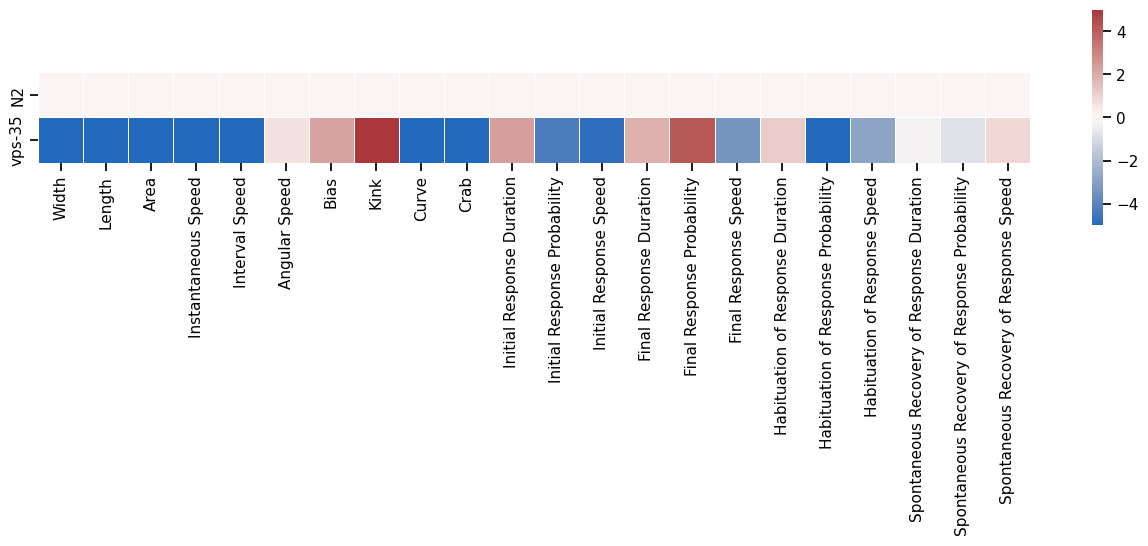

In [96]:
sns.set_context('notebook')
plt.figure(figsize=(16,14))
ax = sns.heatmap(data = PD_gene_Tstats_combined_normalize_heatmap.drop(index="N2"), 
                 annot=False, 
                 linewidth=0.5, 
                 square=True, 
                 cmap='vlag',
#                  cmap=sns.diverging_palette(55, 250, s=100, l=40,as_cmap=True), 
                 center=0, 
                 vmax=5,
                 vmin=-5, 
                 xticklabels=1,
                 yticklabels=1,
                 cbar_kws={"shrink": .2})
ax.set_ylabel('')    
# plt.savefig('Tstat_GENE_normalized_square.png', format='png', dpi=450, bbox_inches = "tight")
plt.show()

In [1]:
# sns.set_context('notebook')
# g = sns.clustermap(PD_gene_Tstats_combined_normalize_heatmap,
#                    cmap='vlag',
# #                    cmap=sns.diverging_palette(55, 250, s=100, l=40,as_cmap=True),
#                    figsize=(8,14),
#                    method="ward",
#                    metric="euclidean", 
#                    col_cluster=False,
#                    linecolor="black",
#                    linewidth=0.01,
#                    dendrogram_ratio=(0.2,0),
#                    vmax=3,
#                    center=0,
#                    vmin=-3,
#                    cbar_pos=(0.95, 0.16, 0.02, 0.18),
#                    tree_kws=dict(linewidths=1.5))
# ax = g.ax_heatmap
# ax.set_ylabel('')  
# # g.savefig("/Users/Joseph/Desktop/GRC_Data/Cluster_edge.png", format='png', dpi=450, bbox_inches='tight')

In [2]:
# sns.set_context('notebook')
# plt.figure(figsize=(20,14))
# ax = sns.heatmap(data = PD_gene_Tstats_combined_normalize_heatmap.drop(index="N2"), 
#                  annot=False, 
#                  linewidth=0.5, 
#                  square=True, 
#                  cmap="vlag", 
#                  center=0, 
#                  vmax=3,
#                  vmin=-3, 
#                  xticklabels=1,
#                  yticklabels=1,
#                  cbar_kws={"shrink": .3})
# ax.set_ylabel('')    
# # plt.savefig('Tstat_GENE_normalized_square_new.png', format='png', dpi=450, bbox_inches = "tight")
# plt.show()

In [99]:
first_col=PD_gene_Tstats_combined_normalize.pop("Area")
PD_gene_Tstats_combined_normalize.insert(0,"Area",first_col)

first_col=PD_gene_Tstats_combined_normalize.pop("Length")
PD_gene_Tstats_combined_normalize.insert(0,"Length",first_col)

first_col=PD_gene_Tstats_combined_normalize.pop("Width")
PD_gene_Tstats_combined_normalize.insert(0,"Width",first_col)

first_col=PD_gene_Tstats_combined_normalize.pop("Angular Speed")
PD_gene_Tstats_combined_normalize.insert(5,"Angular Speed",first_col)

last_col=PD_gene_Tstats_combined_normalize.pop("Spontaneous Recovery of Response Duration")
PD_gene_Tstats_combined_normalize.insert(21,"Spontaneous Recovery of Response Duration",last_col)

last_col=PD_gene_Tstats_combined_normalize.pop("Spontaneous Recovery of Response Probability")
PD_gene_Tstats_combined_normalize.insert(21,"Spontaneous Recovery of Response Probability",last_col)

last_col=PD_gene_Tstats_combined_normalize.pop("Spontaneous Recovery of Response Speed")
PD_gene_Tstats_combined_normalize.insert(21,"Spontaneous Recovery of Response Speed",last_col)

print(PD_gene_Tstats_combined_normalize)

              Width      Length        Area  Instantaneous Speed  \
dataset                                                            
N2         0.000000    0.000000    0.000000             0.000000   
vps-35  -178.326987 -369.010634 -374.212432           -97.525024   

         Interval Speed  Angular Speed      Bias       Kink       Curve  \
dataset                                                                   
N2             0.000000       0.000000  0.000000   0.000000    0.000000   
vps-35      -118.575702       0.634341  2.249195  45.207661 -194.350459   

              Crab  ...  Initial Response Speed  Final Response Duration  \
dataset             ...                                                    
N2        0.000000  ...                0.000000                 0.000000   
vps-35  -41.536186  ...               -4.820497                 1.839241   

         Final Response Probability  Final Response Speed  \
dataset                                                     

## To Graph Phenomic Profile By Gene (Combining Alleles)

In [100]:
PD_gene_Tstats_melted=PD_gene_Tstats_combined_normalize.reset_index()
print(PD_gene_Tstats_melted)
PD_gene_Tstats_melted_gene=pd.melt(PD_gene_Tstats_melted, id_vars=['dataset'],
                                   var_name='Metric',
                                   value_name='Normalized T_score')
PD_gene_Tstats_melted_gene_sorted=PD_gene_Tstats_melted_gene.sort_values(by=['Normalized T_score'])
print(PD_gene_Tstats_melted_gene)
print(PD_gene_Tstats_melted_gene_sorted)
# PD_gene_Tstats_melted_metric=pd.melt(PD_gene_Tstats_melted_gene, id_vars=['dataset'],
#                              value_name='metric')


  dataset       Width      Length        Area  Instantaneous Speed  \
0      N2    0.000000    0.000000    0.000000             0.000000   
1  vps-35 -178.326987 -369.010634 -374.212432           -97.525024   

   Interval Speed  Angular Speed      Bias       Kink       Curve  ...  \
0        0.000000       0.000000  0.000000   0.000000    0.000000  ...   
1     -118.575702       0.634341  2.249195  45.207661 -194.350459  ...   

   Initial Response Speed  Final Response Duration  \
0                0.000000                 0.000000   
1               -4.820497                 1.839241   

   Final Response Probability  Final Response Speed  \
0                     0.00000              0.000000   
1                     4.14347             -3.376077   

   Habituation of Response Duration  Habituation of Response Probability  \
0                          0.000000                              0.00000   
1                          1.203814                             -6.43377   

   Habit

In [101]:
metric_palette=["k","k","k",
                "darkgray","darkgray","darkgray","darkgray","darkgray","darkgray","darkgray",
                "lightsteelblue","lightsteelblue","lightsteelblue",
                "powderblue","powderblue","powderblue",
                "cadetblue","cadetblue","cadetblue",
                "thistle","thistle","thistle"]

In [102]:
PD_gene_Tstats_combined_normalize_orthology_melted=PD_gene_Tstats_combined_normalize_heatmap.reset_index().rename(columns={"Spontaneous Recovery of Response Duration":"Spont. Recov. of Resp. Duration",
                                                                                                                     "Spontaneous Recovery of Response Probability":"Spont. Recov. of Resp. Probability",
                                                                                                                     "Spontaneous Recovery of Response Speed":"Spont. Recov. of Resp. Speed"})
print(PD_gene_Tstats_combined_normalize_orthology_melted)
PD_gene_Tstats_combined_normalize_orthology_melted=pd.melt(PD_gene_Tstats_combined_normalize_orthology_melted, id_vars=['dataset'],
                                   var_name='Metric',
                                   value_name='Normalized T_score')
PD_gene_Tstats_orthology_melted_gene_sorted=PD_gene_Tstats_combined_normalize_orthology_melted.sort_values(by=['Normalized T_score'])
# print(PD_gene_Tstats_melted_gene)
print(PD_gene_Tstats_orthology_melted_gene_sorted)
# PD_gene_Tstats_melted_metric=pd.melt(PD_gene_Tstats_melted_gene, id_vars=['dataset'],
#                              value_name='metric')



  dataset       Width      Length        Area  Instantaneous Speed  \
0      N2    0.000000    0.000000    0.000000             0.000000   
1  vps-35 -178.326987 -369.010634 -374.212432           -97.525024   

   Interval Speed  Angular Speed      Bias       Kink       Curve  ...  \
0        0.000000       0.000000  0.000000   0.000000    0.000000  ...   
1     -118.575702       0.634341  2.249195  45.207661 -194.350459  ...   

   Initial Response Speed  Final Response Duration  \
0                0.000000                 0.000000   
1               -4.820497                 1.839241   

   Final Response Probability  Final Response Speed  \
0                     0.00000              0.000000   
1                     4.14347             -3.376077   

   Habituation of Response Duration  Habituation of Response Probability  \
0                          0.000000                              0.00000   
1                          1.203814                             -6.43377   

   Habit

In [104]:
print(PD_gene_Tstats_melted_gene.dataset.unique())
PD_gene_Tstats_combined_normalize_orthology=PD_gene_Tstats_combined_normalize_heatmap.reset_index()
print(PD_gene_Tstats_combined_normalize_orthology.dataset.unique())

['N2' 'vps-35']
['N2' 'vps-35']


In [105]:
PD_gene_Tstats_combined_normalize_orthology_melted=PD_gene_Tstats_combined_normalize_orthology_melted.rename(columns={"Spontaneous Recovery of Response Duration":"Spont. Recov. of Resp. Duration",
                                                                                                                     "Spontaneous Recovery of Response Probability":"Spont. Recov. of Resp. Probability",
                                                                                                                     "Spontaneous Recovery of Response Speed":"Spont. Recov. of Resp. Speed"})
print(PD_gene_Tstats_combined_normalize_orthology_melted)

   dataset                               Metric  Normalized T_score
0       N2                                Width            0.000000
1   vps-35                                Width         -178.326987
2       N2                               Length            0.000000
3   vps-35                               Length         -369.010634
4       N2                                 Area            0.000000
5   vps-35                                 Area         -374.212432
6       N2                  Instantaneous Speed            0.000000
7   vps-35                  Instantaneous Speed          -97.525024
8       N2                       Interval Speed            0.000000
9   vps-35                       Interval Speed         -118.575702
10      N2                        Angular Speed            0.000000
11  vps-35                        Angular Speed            0.634341
12      N2                                 Bias            0.000000
13  vps-35                                 Bias 

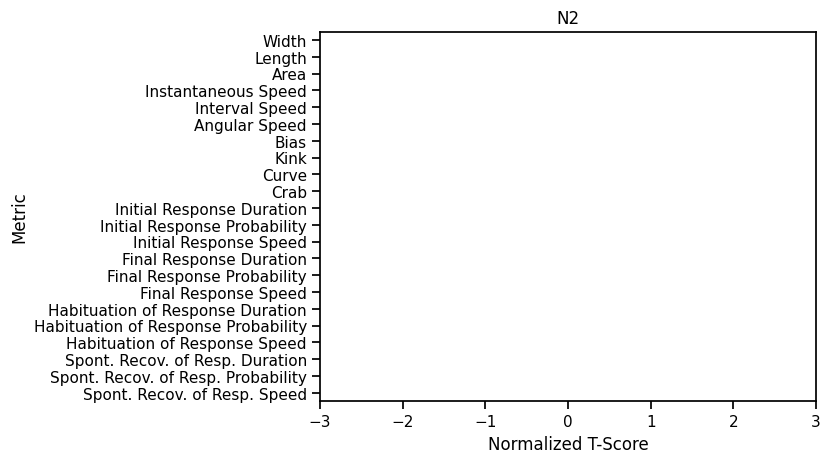

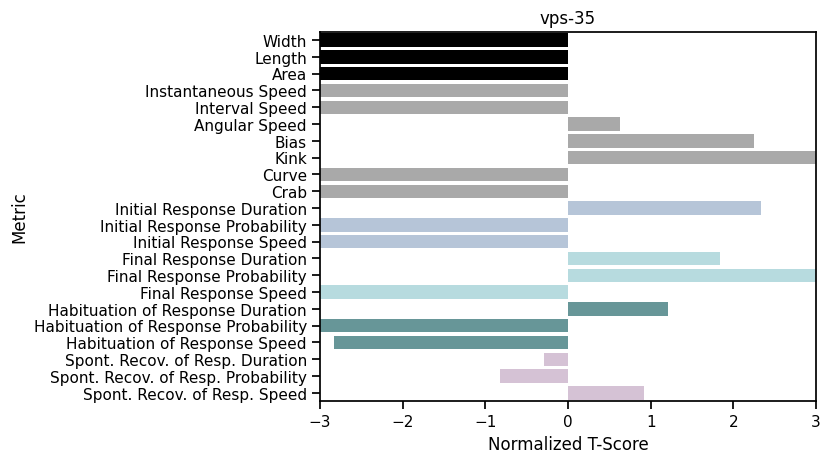

done


In [108]:
# sns.barplot(data=PD_gene_Tstats_melted_gene[PD_gene_Tstats_melted_gene.dataset=="F53B2.5"], x="Metric", y="T_score")
# plt.xticks(rotation=90)

sns.set_context('notebook')
# # plt.figure(figsize=(14,14))
# ax = sns.barplot(data = PD_gene_Tstats_melted_gene[PD_gene_Tstats_melted_gene.dataset=="F53B2.5"], 
#                 x="Metric",
#                 y="T_score",
#                 palette=metric_palette)
# plt.xticks(rotation=90)
# # plt.savefig('/Users/Joseph/Desktop/PD_Screen_TapHab/Tstat_GENE.png', format='png', dpi=450, bbox_inches = "tight")
# # '/Users/Joseph/Desktop/PD_Screen_TapHab/Baseline100Data.csv'
# plt.show()

for x in PD_gene_Tstats_combined_normalize_orthology_melted.dataset.unique():
    plt.figure()
    ax = sns.barplot(data = PD_gene_Tstats_combined_normalize_orthology_melted[PD_gene_Tstats_combined_normalize_orthology_melted.dataset==f"{x}"], 
                x="Normalized T_score",
                y="Metric", orient='h',
                palette=metric_palette).set_title(f"{x}")
    plt.xlim(-3,3)
    plt.xlabel('Normalized T-Score')
#     plt.xticks(rotation=90)
    # plt.savefig(f'{x}_Metrics.png', format='png', dpi=450, bbox_inches = "tight")
    plt.show()
print("done")

## To Graph Genes Breakdown By Phenotype

In [109]:
# print(PD_gene_Tstats_combined)
PD_gene_Tstats_combined_melted=PD_gene_Tstats_combined.reset_index()
PD_gene_Tstats_combined_melted=pd.melt(PD_gene_Tstats_combined_melted, id_vars=['dataset'],
                                   var_name='Metric',
                                   value_name='T_score')
PD_gene_Tstats_combined_melted_sorted=PD_gene_Tstats_combined_melted.sort_values(by=['T_score'])
# print(PD_gene_Tstats_melted_gene)
print(PD_gene_Tstats_combined_melted_sorted)

   dataset                                        Metric     T_score
5   vps-35                                          Area -374.212432
3   vps-35                                        Length -369.010634
17  vps-35                                         Curve -194.350459
1   vps-35                                         Width -178.326987
9   vps-35                                Interval Speed -118.575702
7   vps-35                           Instantaneous Speed  -97.525024
19  vps-35                                          Crab  -41.536186
35  vps-35           Habituation of Response Probability   -6.433770
25  vps-35                        Initial Response Speed   -4.820497
23  vps-35                  Initial Response Probability   -4.298196
31  vps-35                          Final Response Speed   -3.376077
37  vps-35                 Habituation of Response Speed   -2.836258
41  vps-35  Spontaneous Recovery of Response Probability   -0.825120
39  vps-35     Spontaneous Recover

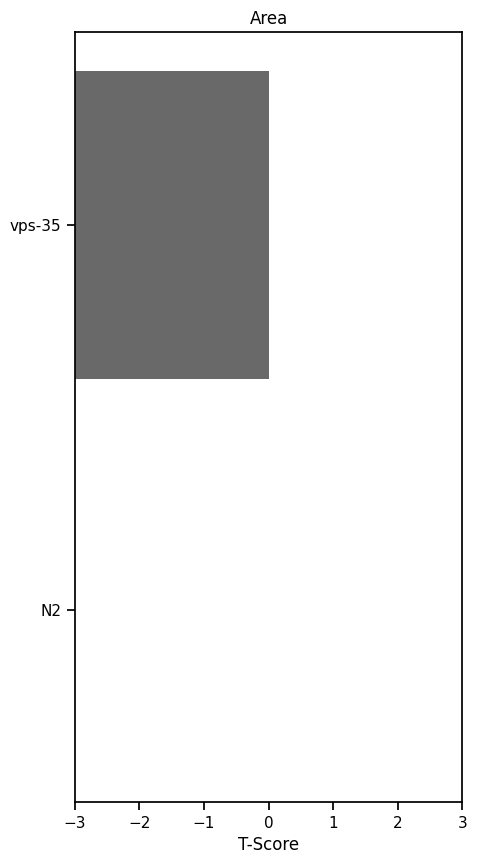

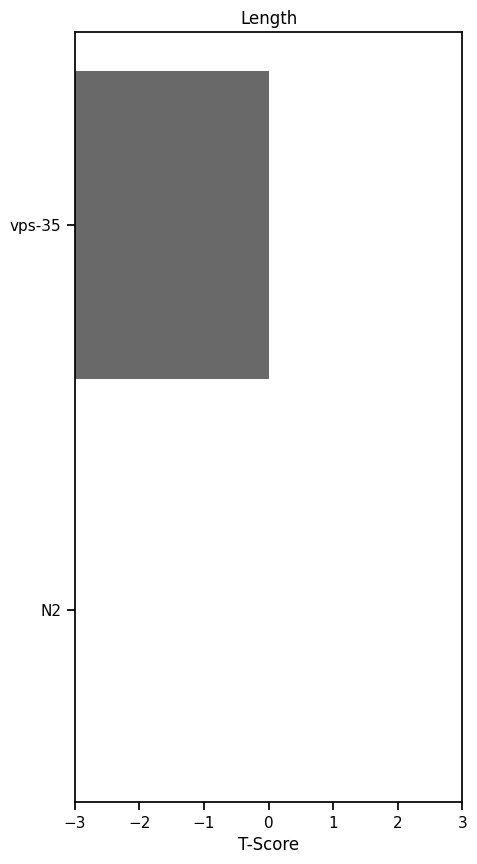

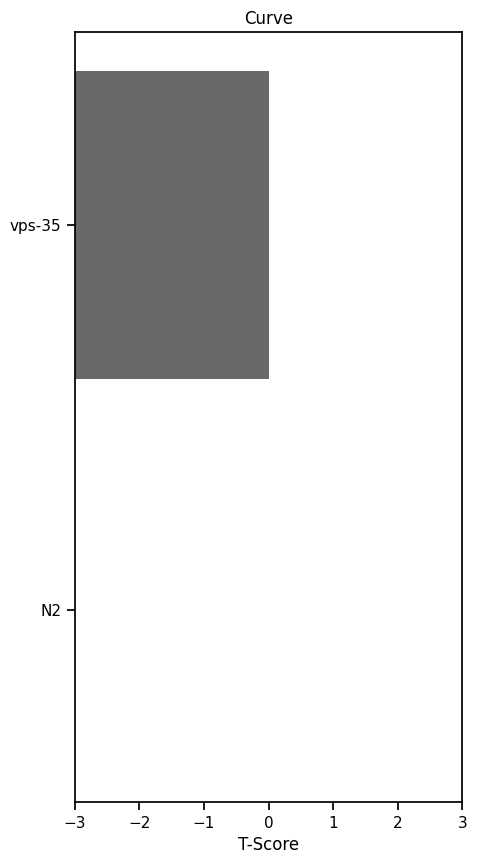

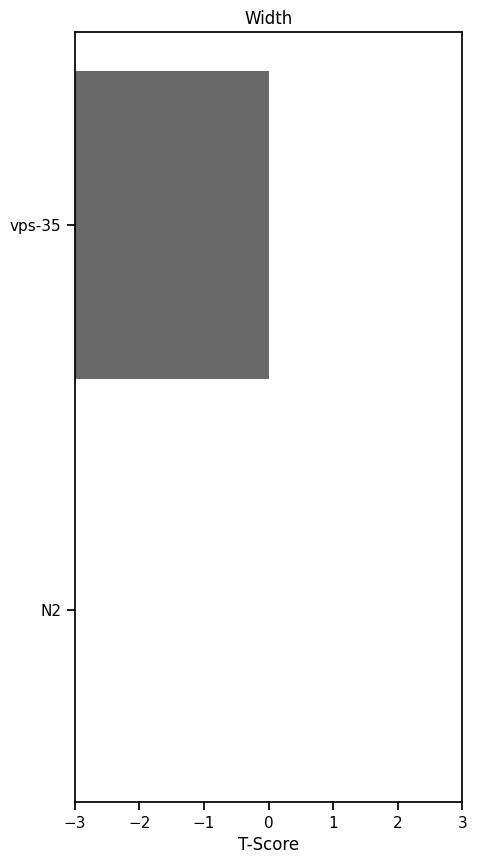

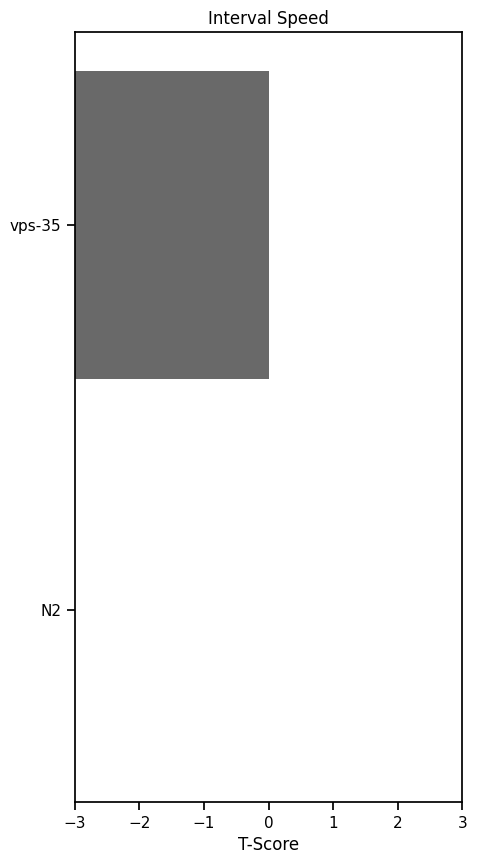

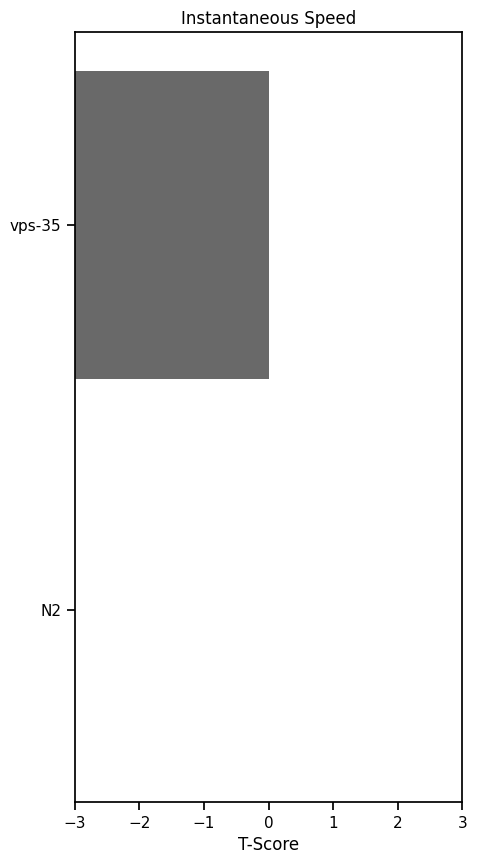

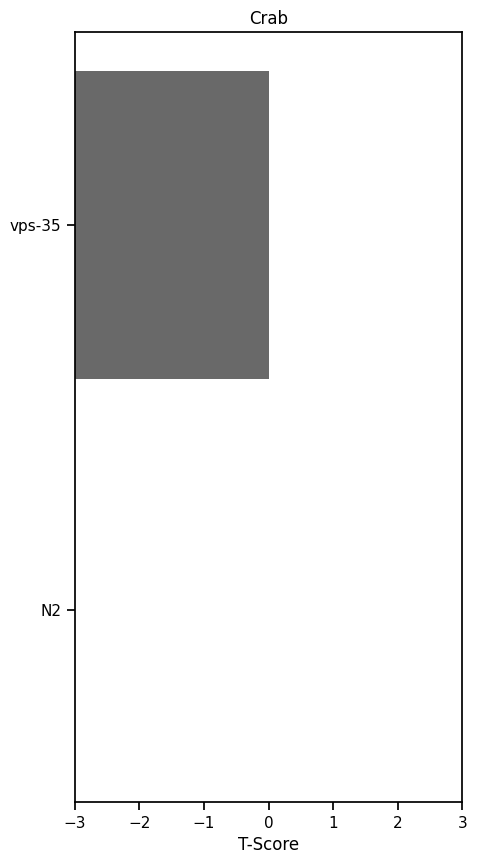

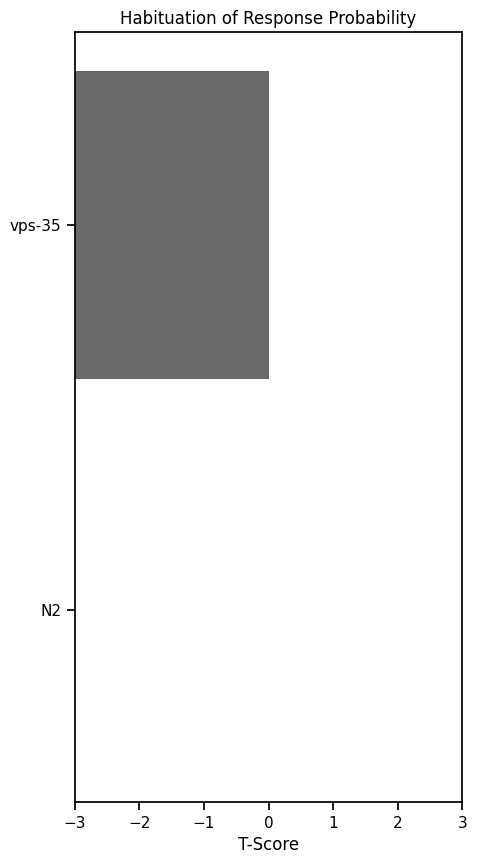

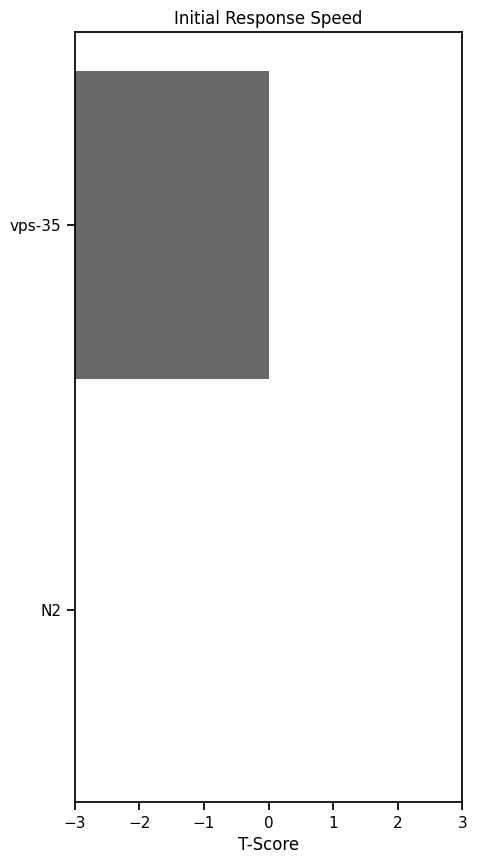

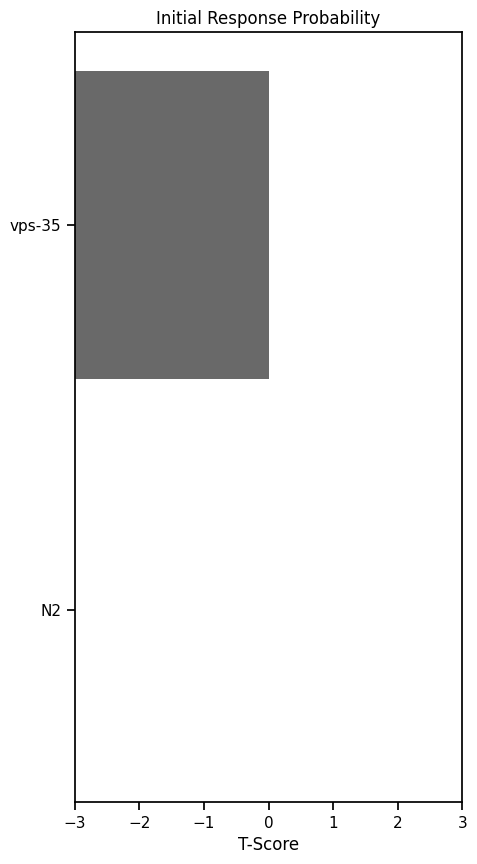

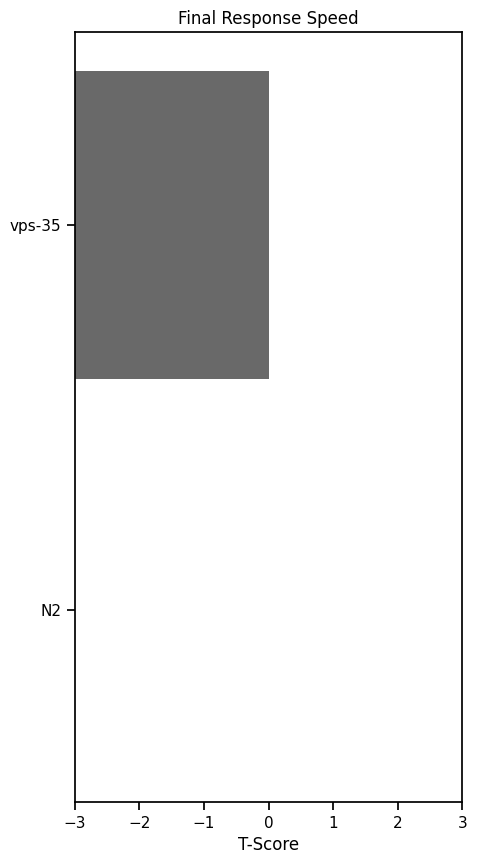

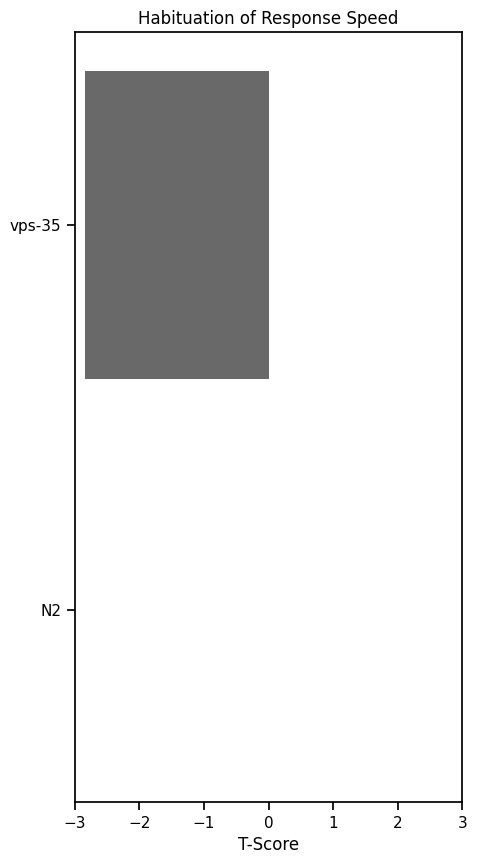

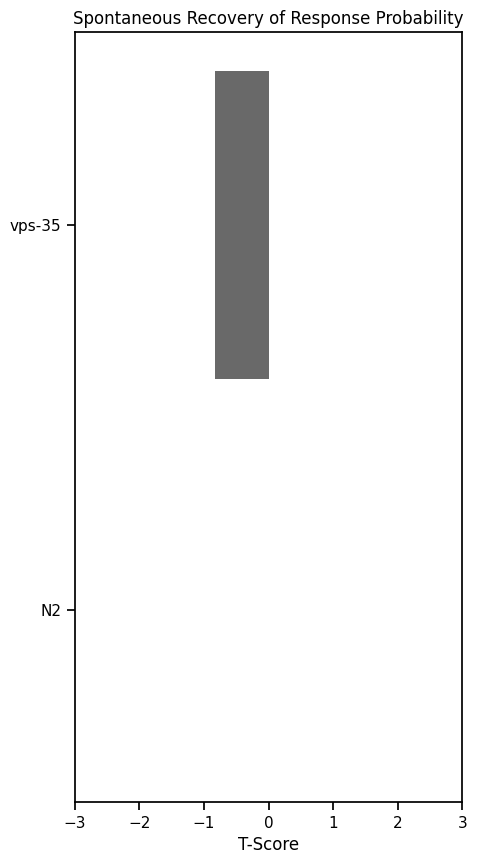

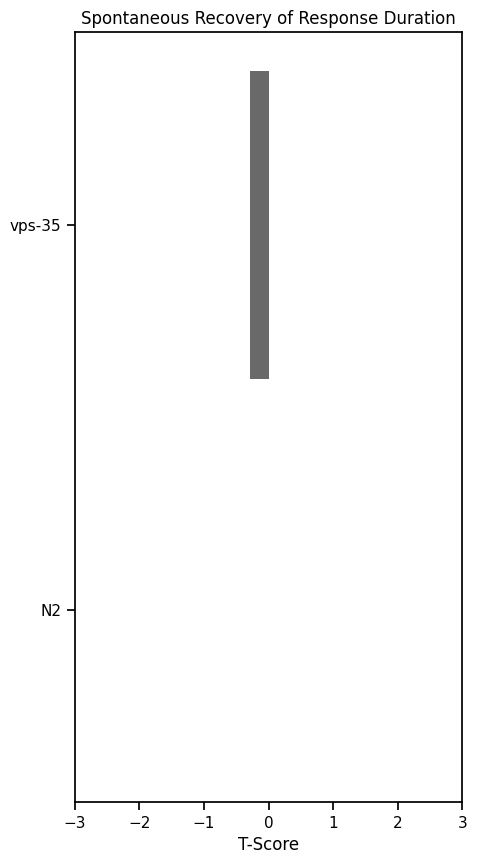

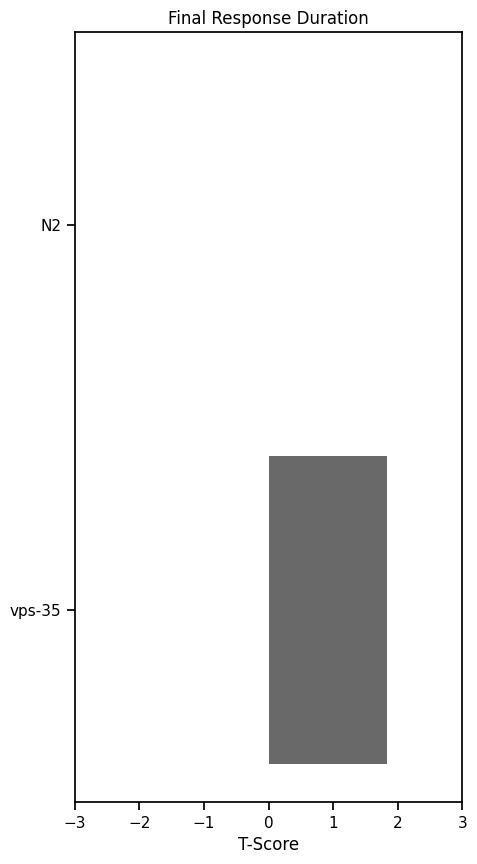

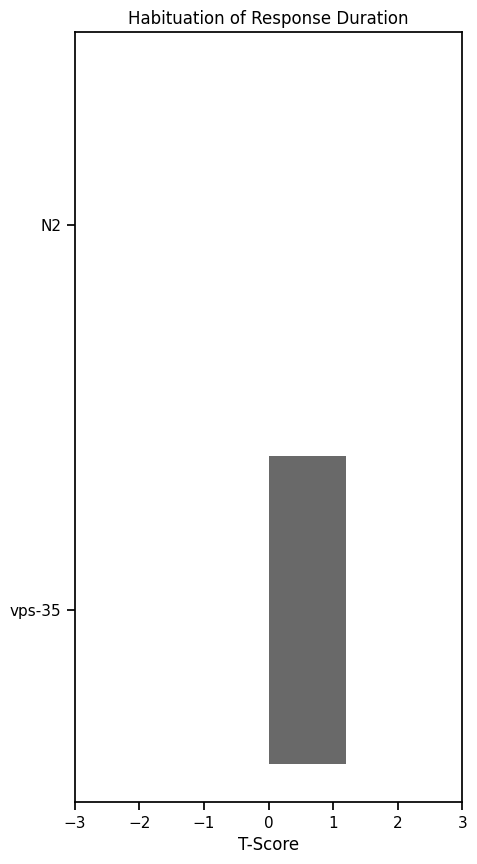

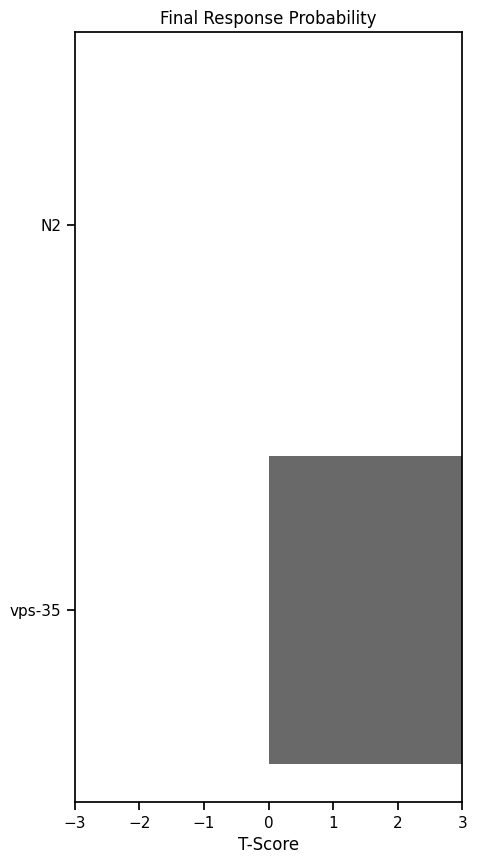

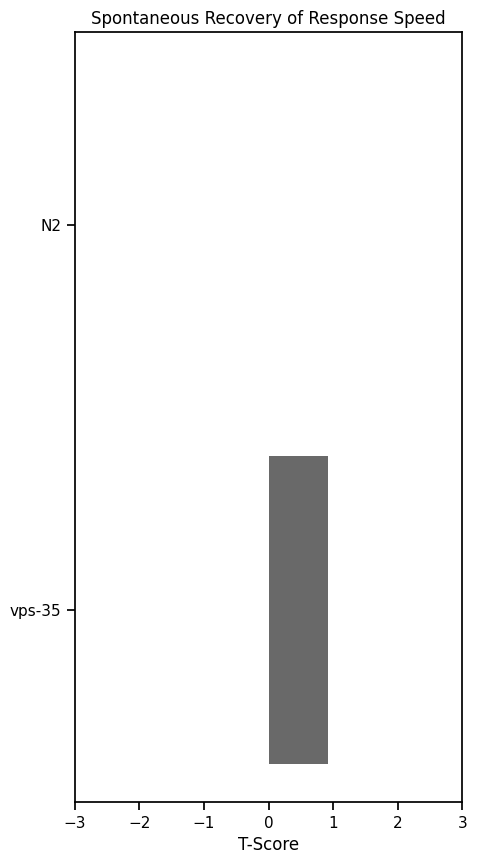

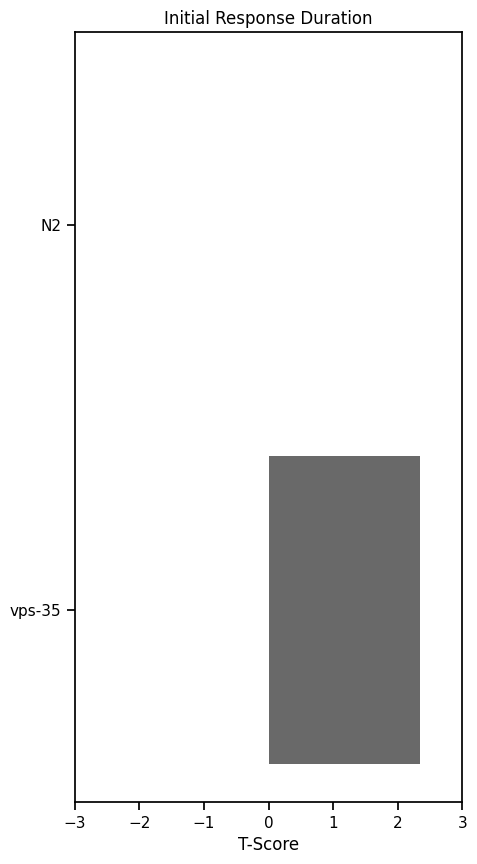

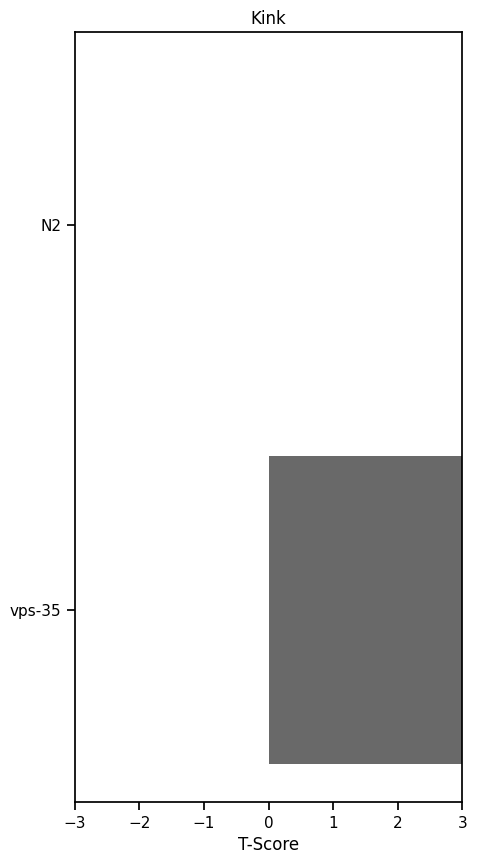

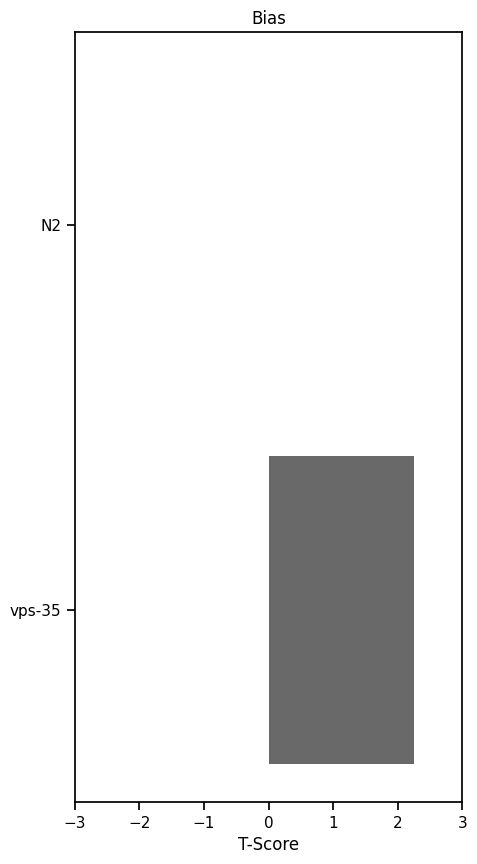

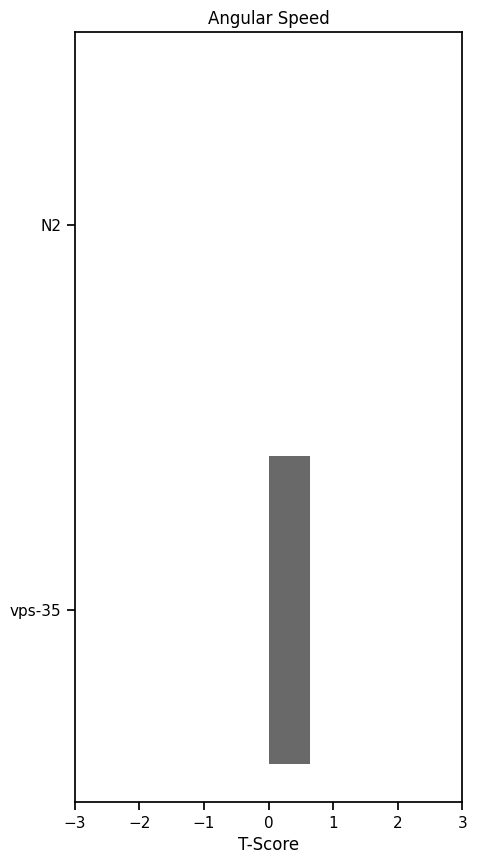

done


In [111]:
# sns.barplot(data=PD_gene_Tstats_melted_gene_sorted[PD_gene_Tstats_melted_gene_sorted.Metric=="Instantaneous Speed"],
#             x="dataset", y="T_score")
# plt.xticks(rotation=90)

for x in PD_gene_Tstats_combined_melted_sorted.Metric.unique():
    plt.figure(figsize=(5,10))
    ax = sns.barplot(data = PD_gene_Tstats_combined_melted_sorted[PD_gene_Tstats_combined_melted_sorted.Metric==f"{x}"], 
                x="T_score",
                y="dataset",orient='h',
                palette=["dimgray"]).set_title(f"{x}")
#     plt.xticks(rotation=90)
    plt.xlabel('T-Score')
    plt.ylabel('')
    plt.xlim(-3,3)
    # plt.savefig(f'{x}_Metrics.png', format='png', dpi=450, bbox_inches = "tight")
    plt.show()
print("done")